# ECE 657A - Assignment 2
**Date Submitted:** March 11, 2022

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Charting
import seaborn as sns
sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
from scipy import stats
from mlxtend.plotting import plot_confusion_matrix

# Misc
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display

# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

# PCA, LDA, t-SNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE

# Naive Bayes'
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB

# Decision Tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

#For Random forest and gradient boosting
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# 0. Preprocessed data

What: This is an exploratory data analysis step

Why: This step gives useful insights about data and tells if there's a need clean, scale or normalize the data.

How: We start by importing the dataset. Then we encode the feature 'Sex'. After that we perform minmax and zscore normalization

## 0.1. Abalone Dataset

In [2]:
# Columns/Features of Dataset
abalone_columns = ['Sex','Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight','Rings']

# Loading the Data set
abalone_df=pd.read_csv('abalone.csv',names=abalone_columns)

In [3]:
# Encoding the dataset
abalone_df['Sex'] = abalone_df['Sex'].replace(['M'],'0')
abalone_df['Sex'] = abalone_df['Sex'].replace(['F'],'1')
abalone_df['Sex'] = abalone_df['Sex'].replace(['I'],'2')

abalone_df.head()

Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   0   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   0   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   1   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   0   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   2   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell weight  Rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7

### 0.1.1. Z-score Normalization

What: the process of normalizing every value in a dataset such that the mean of all of the values is 0 and the standard deviation is 1.

Why: To have a consistent scale of values

How: use function 'stats.zscore'

In [4]:
# Z-score Normalization
abalone_for_normalization = abalone_df.drop(columns=['Rings','Sex']) # Copy the dataset without some columns
abalone_zscore = abalone_for_normalization.apply(stats.zscore) # Z-score
abalone_zscore['Sex'] = abalone_df['Sex'] 
abalone_zscore['Rings'] = abalone_df['Rings']
abalone_zscore.head()

Length  Diameter    Height  Whole weight  Shucked weight  Viscera weight  \
0 -0.574558 -0.432149 -1.064424     -0.641898       -0.607685       -0.726212   
1 -1.448986 -1.439929 -1.183978     -1.230277       -1.170910       -1.205221   
2  0.050033  0.122130 -0.107991     -0.309469       -0.463500       -0.356690   
3 -0.699476 -0.432149 -0.347099     -0.637819       -0.648238       -0.607600   
4 -1.615544 -1.540707 -1.423087     -1.272086       -1.215968       -1.287337   

   Shell weight Sex  Rings  
0     -0.638217   0     15  
1     -1.212987   0      7  
2     -0.207139   1      9  
3     -0.602294   0     10  
4     -1.320757   2      7

### 0.1.2. Min-max Normalization


What: For every feature, the minimum value of that feature gets transformed into a 0, the maximum value gets transformed into a 1, and every other value gets transformed into a decimal between 0 and 1.

Why: To have a consistent scale of values

How: Use library 'sklearn.preprocessing' and method 'MinMaxScaler'

In [5]:
# Minmax normalization
from sklearn.preprocessing import MinMaxScaler

abalone_for_normalization = abalone_df.drop(columns=['Sex']) # Copy the dataset without some columns
cols = list(abalone_for_normalization.columns) # Get column names
scaler_minmax = MinMaxScaler() # Minmax object
features_data_x = abalone_for_normalization.drop('Rings', axis = 1).values # Flatten the dataset
target_y = abalone_for_normalization['Rings'].values
X_minmax = scaler_minmax.fit_transform(features_data_x)

In [6]:
# Dataframe of minmax normalized data
abalone_minmax = pd.DataFrame(data=np.column_stack((X_minmax, target_y)),columns=cols)
abalone_minmax['Sex'] = abalone_df['Sex']
abalone_minmax.head()

Length  Diameter    Height  Whole weight  Shucked weight  Viscera weight  \
0  0.513514  0.521008  0.084071      0.181335        0.150303        0.132324   
1  0.371622  0.352941  0.079646      0.079157        0.066241        0.063199   
2  0.614865  0.613445  0.119469      0.239065        0.171822        0.185648   
3  0.493243  0.521008  0.110619      0.182044        0.144250        0.149440   
4  0.344595  0.336134  0.070796      0.071897        0.059516        0.051350   

   Shell weight  Rings Sex  
0      0.147982   15.0   0  
1      0.068261    7.0   0  
2      0.207773    9.0   1  
3      0.152965   10.0   0  
4      0.053313    7.0   2

## 0.2. Wine Quality Dataset

In [7]:
#Columns/Features
wine_columns = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
L = 'quality'
C = 'color'

#Loading Data set
wine_r = pd.read_csv("winequality-red.csv", sep=';')
#Loading Data set
wine_w = pd.read_csv("winequality-white.csv", sep=';')

# Combining the datasets
wine_w= wine_w.copy()
wine_w[C]= np.zeros(wine_w.shape[0],dtype=int)
wine_r[C]= np.ones(wine_r.shape[0],dtype=int)
wine_df = pd.concat([wine_w,wine_r])
wine_df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  color  
0      8.8        6      0  
1      9.5        6      0  
2     10.1        6      0  
3      9.9        6      0  
4      9.9        6      0

### 0.2.1. Z-score Normalization

What: the process of normalizing every value in a dataset such that the mean of all of the values is 0 and the standard deviation is 1.

Why: To have a consistent scale of values

How: use function 'stats.zscore'

In [8]:
# With Z-score Normalization
wine_zscore = wine_df.loc[:, ~wine_df.columns.isin(['quality', 'color'])].apply(stats.zscore)
wine_zscore["quality"] = wine_df["quality"]
wine_zscore["color"] = wine_df["color"]

wine_zscore.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.166089         -0.423183     0.284686        3.206929  -0.314975   
1      -0.706073         -0.240949     0.147046       -0.807837  -0.200790   
2       0.682458         -0.362438     0.559966        0.306208  -0.172244   
3      -0.011808         -0.666161     0.009406        0.642523   0.056126   
4      -0.011808         -0.666161     0.009406        0.642523   0.056126   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0             0.815565              0.959976  2.102214 -1.359049  -0.546178   
1            -0.931107              0.287618 -0.232332  0.506915  -0.277351   
2            -0.029599             -0.331660  0.134525  0.258120  -0.613385   
3             0.928254              1.243074  0.301278 -0.177272  -0.882212   
4             0.928254              1.243074  0.301278 -0.177272  -0.882212   

    alcohol  quality  color  
0 -1.418558        6      0  
1 -0.831615        6      0  
2 -0.328521        6      0  
3 -0.496219        6      0  
4 -0.496219        6      0

### 0.2.2. Min-max Normalization


What: For every feature, the minimum value of that feature gets transformed into a 0, the maximum value gets transformed into a 1, and every other value gets transformed into a decimal between 0 and 1.

Why: To have a consistent scale of values

How: Use library 'sklearn.preprocessing' and method 'MinMaxScaler'

In [9]:
#Minmax normalization
wine_minmax = (wine_df-wine_df.min())/(wine_df.max()-wine_df.min())
wine_minmax["quality"] = wine_df["quality"]
wine_minmax["color"] = wine_df["color"]

wine_minmax.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       0.264463          0.126667     0.216867        0.308282   0.059801   
1       0.206612          0.146667     0.204819        0.015337   0.066445   
2       0.355372          0.133333     0.240964        0.096626   0.068106   
3       0.280992          0.100000     0.192771        0.121166   0.081395   
4       0.280992          0.100000     0.192771        0.121166   0.081395   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0             0.152778              0.377880  0.267785  0.217054   0.129213   
1             0.045139              0.290323  0.132832  0.449612   0.151685   
2             0.100694              0.209677  0.154039  0.418605   0.123596   
3             0.159722              0.414747  0.163678  0.364341   0.101124   
4             0.159722              0.414747  0.163678  0.364341   0.101124   

    alcohol  quality  color  
0  0.115942        6      0  
1  0.217391        6      0  
2  0.304348        6      0  
3  0.275362        6      0  
4  0.275362        6      0

## 0.3. KNN

What: k-nearest neighbors algorithm (k-NN) is a non-parametric supervised learning method used for classification and regression. In both cases, the input consists of the k closest training examples in a data set. 

Why: The objective is to build a prediction model for datasets

How: We use the method 'KNeighborsClassifier' from 'sklearn.neighbors'

### 0.3.0. Functions

In [10]:
# Creating functions to generate a train-test split and analyzing the train test split
from sklearn.model_selection import train_test_split

def generate_train_test_splits(df,target):
    X = df.drop(target, axis = 1)
    y = df[target]

    # Train and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=27)
    return X_train, X_test, y_train, y_test

def analyze_train_test_splits(*args):
    for split in args:
        display(split.count())

In [11]:
# Defining wrapper functions for KNN classification for reusability

# The below function accepts train-test splits, value of k, method(for weighted KNN) as "e"(euclidean) or "m"(manhattan) and returns accuracy
def knn_classify(X_train, X_test, y_train, y_test,n=None,method=None):
    knn_args = {}

    # Assessing the arguments
    if n is not None:
        knn_args['n_neighbors'] = n
    
    if method == "e":
        knn_args['weights'] = "distance"
        
    if method == "m":
        knn_args['weights'] = "distance"
        knn_args['metric'] = "manhattan"

    # Run KNN based upon arguments passed to the current function
    knn = KNeighborsClassifier(**knn_args) # Defining model
    knn.fit(X_train, y_train) # Running the model
    predictions = knn.predict(X_test) # Making predictions
    accuracy = accuracy_score(y_test,predictions) # Calculating accuracy
    return accuracy

# The below function is just to analyze the predictions, confusion matrix
def knn_analyze(predictions,y_test): 
    print("\n*** Confusion Matrix ***\n")
    print(confusion_matrix(y_test,predictions))
    
    print("\n*** Classification Report ***\n")
    print(classification_report(y_test,predictions))
    
    accuracy = accuracy_score(y_test,predictions)
    
    print("\n*** Accuracy ***\n")
    print(accuracy)

### 0.3.1. Abalone

In [12]:
# Using three datasets: unnormalized, zscore normalized and minmax normalized
abalone_dataframe_unnormal = abalone_df
abalone_dataframe_zscore = abalone_zscore
abalone_dataframe_minmax = abalone_minmax

abalone_target = "Rings" # Target variable

In [13]:
# Train, test set for zscore normalized
abalone_zscore_X_train, abalone_zscore_X_test, abalone_zscore_y_train, abalone_zscore_y_test = generate_train_test_splits(abalone_dataframe_zscore,abalone_target)
# Train, test set for minmax normalized
abalone_minmax_X_train, abalone_minmax_X_test, abalone_minmax_y_train, abalone_minmax_y_test = generate_train_test_splits(abalone_dataframe_minmax,abalone_target)

print("\n*** Analysis for zscore normalized ***\n")
# analyze_train_test_splits(abalone_zscore_X_train, abalone_zscore_X_test, abalone_zscore_y_train, abalone_zscore_y_test)

print("\n*** Analysis for minmax normalized ***\n")
# analyze_train_test_splits(abalone_minmax_X_train, abalone_minmax_X_test, abalone_minmax_y_train, abalone_minmax_y_test)


*** Analysis for zscore normalized ***


*** Analysis for minmax normalized ***



In [14]:
# Calculating accuracy for default value of k i.e. 5
abalone_zscore_accuracy = knn_classify(abalone_zscore_X_train, abalone_zscore_X_test, abalone_zscore_y_train, abalone_zscore_y_test)
abalone_minmax_accuracy = knn_classify(abalone_minmax_X_train, abalone_minmax_X_test, abalone_minmax_y_train, abalone_minmax_y_test)

In [15]:
print("Accuracy for zscore = {}".format(abalone_zscore_accuracy))
print("Accuracy for minmax = {}".format(abalone_minmax_accuracy))

Accuracy for zscore = 0.22009569377990432
Accuracy for minmax = 0.22009569377990432


In [16]:
#k_values = [1,5,10,15,20,25,30,35]
k_values = range(4,100)
abalone_zscore_accuracies = []
abalone_minmax_accuracies = []

for k in k_values:
    acc1 = knn_classify(abalone_zscore_X_train, abalone_zscore_X_test, abalone_zscore_y_train, abalone_zscore_y_test,k)
    acc2 = knn_classify(abalone_minmax_X_train, abalone_minmax_X_test, abalone_minmax_y_train, abalone_minmax_y_test,k)
    
    abalone_zscore_accuracies.append(acc1)
    abalone_minmax_accuracies.append(acc2)

# Multiplying accuracies by 100 for better comparison
abalone_zscore_accuracies = [x*100 for x in abalone_zscore_accuracies]
abalone_minmax_accuracies = [x*100 for x in abalone_minmax_accuracies]

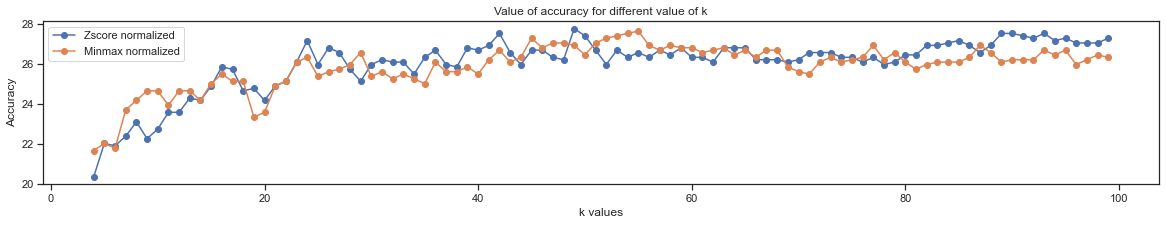

In [17]:
# Plotting the graph between different values of 'k' and accuracy
plt.figure(figsize=(20,3))
plt.plot(k_values, abalone_zscore_accuracies, marker='o')
plt.plot(k_values, abalone_minmax_accuracies, marker='o')

plt.xlabel("k values")
plt.ylabel("Accuracy")
plt.title("Value of accuracy for different value of k")
plt.legend(["Zscore normalized","Minmax normalized"])

In [18]:
# Finding the maximum accuracy
zscore_max_accuracy = max(abalone_zscore_accuracies)
minmax_max_accuracy = max(abalone_minmax_accuracies)

# Finding the best value of k
zscore_best_k = k_values[abalone_zscore_accuracies.index(zscore_max_accuracy)]
minmax_best_k = k_values[abalone_minmax_accuracies.index(minmax_max_accuracy)]

print("*** Best value of k for zscore = {} ***".format(zscore_best_k))
print("*** Best value of k for minmax = {} ***".format(minmax_best_k))

*** Best value of k for zscore = 49 ***
*** Best value of k for minmax = 55 ***


In [19]:
# Storing the accuracies for different k-values and different weighting parameters for zscore and minmax normalized data
abalone_zscore_accuracies_manhattan = []
abalone_zscore_accuracies_euclidean = []

abalone_minmax_accuracies_manhattan = []
abalone_minmax_accuracies_euclidean = []

# Using 'knn_classify' wrapper function defined above
for k in k_values:
    acc1_m = knn_classify(abalone_zscore_X_train, abalone_zscore_X_test, abalone_zscore_y_train, abalone_zscore_y_test,k,"m")
    acc1_e = knn_classify(abalone_zscore_X_train, abalone_zscore_X_test, abalone_zscore_y_train, abalone_zscore_y_test,k,"e")
    
    acc2_m = knn_classify(abalone_minmax_X_train, abalone_minmax_X_test, abalone_minmax_y_train, abalone_minmax_y_test,k,"m")
    acc2_e = knn_classify(abalone_minmax_X_train, abalone_minmax_X_test, abalone_minmax_y_train, abalone_minmax_y_test,k,"e")
    
    abalone_zscore_accuracies_manhattan.append(acc1_m)
    abalone_zscore_accuracies_euclidean.append(acc1_e)

    abalone_minmax_accuracies_manhattan.append(acc2_m)
    abalone_minmax_accuracies_euclidean.append(acc2_e)

In [20]:
# Multiplying accuracies by 100 for better comparison
abalone_zscore_accuracies_manhattan = [x*100 for x in abalone_zscore_accuracies_manhattan] 
abalone_zscore_accuracies_euclidean = [x*100 for x in abalone_zscore_accuracies_euclidean] 

abalone_minmax_accuracies_manhattan = [x*100 for x in abalone_minmax_accuracies_manhattan] 
abalone_minmax_accuracies_euclidean = [x*100 for x in abalone_minmax_accuracies_euclidean] 

*** Plot for Zscore normalized values ***


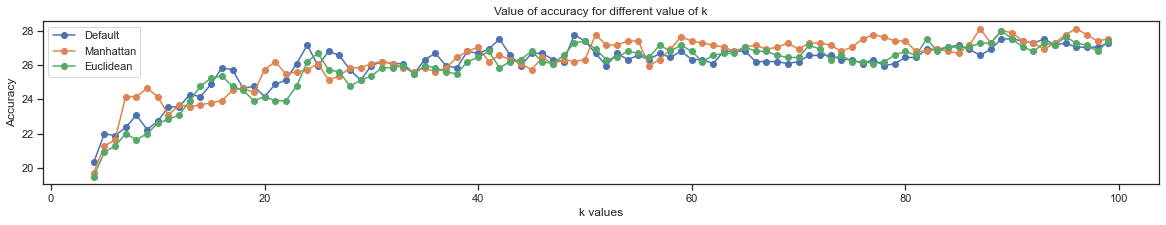

*** Plot for Minmax normalized values ***


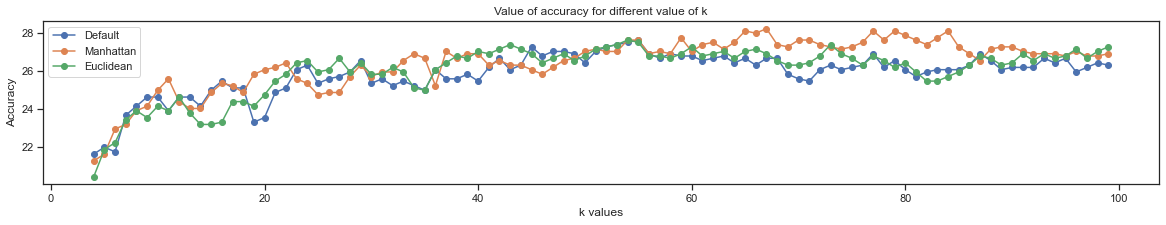

In [21]:
# Creating a function to create the plots
def accuracy_plot(default,manhattan,euclidean):
    plt.figure(figsize=(20,3))
    plt.plot(k_values, default, label='Default', marker='o')
    plt.plot(k_values, manhattan, label="Manhattan", marker='o')
    plt.plot(k_values, euclidean, label="Euclidean", marker='o')

    plt.xlabel("k values")
    plt.ylabel("Accuracy")
    plt.title("Value of accuracy for different value of k")
    plt.legend(["Default","Manhattan","Euclidean"])
    plt.show()

print("*** Plot for Zscore normalized values ***")
accuracy_plot(abalone_zscore_accuracies,abalone_zscore_accuracies_manhattan,abalone_zscore_accuracies_euclidean)

print("*** Plot for Minmax normalized values ***")
accuracy_plot(abalone_minmax_accuracies,abalone_minmax_accuracies_manhattan,abalone_minmax_accuracies_euclidean)

In [22]:
'''
    Finding the maximum accuracy
'''
zscore_max_accuracy_manhattan = max(abalone_zscore_accuracies_manhattan)
zscore_max_accuracy_euclidean = max(abalone_zscore_accuracies_euclidean)

print("*** Best accuracy from zscore = {} ***".format(max(zscore_max_accuracy,zscore_max_accuracy_manhattan,zscore_max_accuracy_euclidean)))
print("*** zscore = {} ***".format(zscore_max_accuracy))
print("*** zscore manhattan= {} ***".format(zscore_max_accuracy_manhattan))
print("*** zscore euclidean= {} ***".format(zscore_max_accuracy_euclidean))

minmax_max_accuracy_manhattan = max(abalone_minmax_accuracies_manhattan)
minmax_max_accuracy_euclidean = max(abalone_minmax_accuracies_euclidean)

print("*** Best accuracy from minmax = {} ***".format(max(minmax_max_accuracy,minmax_max_accuracy_manhattan,minmax_max_accuracy_euclidean)))
print("*** minmax = {} ***".format(minmax_max_accuracy))
print("*** minmax manhattan= {} ***".format(minmax_max_accuracy_manhattan))
print("*** minmax euclidean= {} ***".format(minmax_max_accuracy_euclidean))

''' 
    Finding the best value of k
'''
zscore_best_k_manhattan = k_values[abalone_zscore_accuracies_manhattan.index(zscore_max_accuracy_manhattan)]
zscore_best_k_euclidean = k_values[abalone_zscore_accuracies_euclidean.index(zscore_max_accuracy_euclidean)]

minmax_best_k_manhattan = k_values[abalone_minmax_accuracies_manhattan.index(minmax_max_accuracy_manhattan)]
minmax_best_k_euclidean = k_values[abalone_minmax_accuracies_euclidean.index(minmax_max_accuracy_euclidean)]
print("\n")
print("*** Best value of k for zscore for manhattan distance metric= {} ***".format(zscore_best_k_manhattan))
print("*** Best value of k for zscore for euclidean distance metric= {} ***".format(zscore_best_k_euclidean))

print("*** Best value of k for minmax for manhattan distance metric= {} ***".format(minmax_best_k_manhattan))
print("*** Best value of k for minmax for euclidean distance metric= {} ***".format(minmax_best_k_euclidean))

*** Best accuracy from zscore = 28.11004784688995 ***
*** zscore = 27.751196172248804 ***
*** zscore manhattan= 28.11004784688995 ***
*** zscore euclidean= 27.990430622009573 ***
*** Best accuracy from minmax = 28.22966507177033 ***
*** minmax = 27.631578947368425 ***
*** minmax manhattan= 28.22966507177033 ***
*** minmax euclidean= 27.631578947368425 ***


*** Best value of k for zscore for manhattan distance metric= 87 ***
*** Best value of k for zscore for euclidean distance metric= 89 ***
*** Best value of k for minmax for manhattan distance metric= 67 ***
*** Best value of k for minmax for euclidean distance metric= 54 ***


In [23]:
# Getting the best dataset, 'k' and weighing method
abalone_raw = abalone_minmax
abalone_best_k = 87
abalone_best_weight = "m"

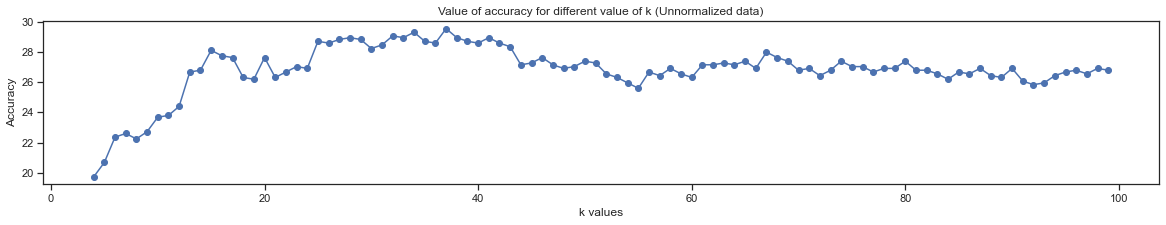

*** Plot for Unnormalized values ***


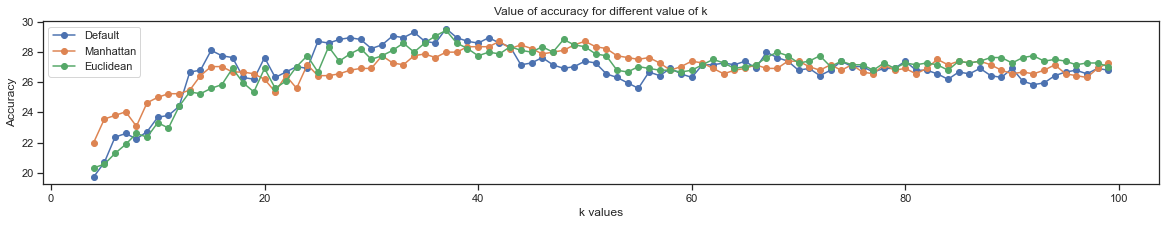

In [24]:
# Splitting unnormalized data into training and testing set
abalone_unnormal_X_train, abalone_unnormal_X_test, abalone_unnormal_y_train, abalone_unnormal_y_test = generate_train_test_splits(abalone_dataframe_unnormal,abalone_target)

# Calculating accuracy
abalone_unnormal_accuracy = knn_classify(abalone_unnormal_X_train, abalone_unnormal_X_test, abalone_unnormal_y_train, abalone_unnormal_y_test)

abalone_unnormal_accuracies = []
for k in k_values:
    acc1 = knn_classify(abalone_unnormal_X_train, abalone_unnormal_X_test, abalone_unnormal_y_train, abalone_unnormal_y_test,k)
    abalone_unnormal_accuracies.append(acc1)    
    
abalone_unnormal_accuracies = [x*100 for x in abalone_unnormal_accuracies]
plt.figure(figsize=(20,3))
plt.plot(k_values, abalone_unnormal_accuracies, marker='o')
plt.title("Value of accuracy for different value of k (Unnormalized data)")
plt.xlabel("k values")
plt.ylabel("Accuracy")
plt.show()

# Trying manhatten and euclidean metrics for unnormalized data
abalone_unnormal_accuracies_manhattan = []
abalone_unnormal_accuracies_euclidean = []

for k in k_values:
    acc1_m = knn_classify(abalone_unnormal_X_train, abalone_unnormal_X_test, abalone_unnormal_y_train, abalone_unnormal_y_test,k,"m")
    acc1_e = knn_classify(abalone_unnormal_X_train, abalone_unnormal_X_test, abalone_unnormal_y_train, abalone_unnormal_y_test,k,"e")
    abalone_unnormal_accuracies_manhattan.append(acc1_m)
    abalone_unnormal_accuracies_euclidean.append(acc1_e)

abalone_unnormal_accuracies_manhattan = [x*100 for x in abalone_unnormal_accuracies_manhattan] 
abalone_unnormal_accuracies_euclidean = [x*100 for x in abalone_unnormal_accuracies_euclidean]

print("*** Plot for Unnormalized values ***")
accuracy_plot(abalone_unnormal_accuracies,abalone_unnormal_accuracies_manhattan,abalone_unnormal_accuracies_euclidean)

In [25]:
# Finding the maximum accuracy
unnormal_max_accuracy = max(abalone_unnormal_accuracies)
unnormal_max_accuracy_manhattan = max(abalone_unnormal_accuracies_manhattan)
unnormal_max_accuracy_euclidean = max(abalone_unnormal_accuracies_euclidean)

print("*** Best accuracy from unnormalized data = {} ***".format(max(unnormal_max_accuracy,unnormal_max_accuracy_manhattan,unnormal_max_accuracy_euclidean)))

# Finding the best value of k
unnormal_best_k = k_values[abalone_unnormal_accuracies.index(unnormal_max_accuracy)]
unnormal_best_k_manhattan = k_values[abalone_unnormal_accuracies_manhattan.index(unnormal_max_accuracy_manhattan)]
unnormal_best_k_euclidean = k_values[abalone_unnormal_accuracies_euclidean.index(unnormal_max_accuracy_euclidean)]

print("*** Best value of k for unnormalized distance metric= {} ***".format(unnormal_best_k))
print("*** Best value of k for unnormalized for manhattan distance metric= {} ***".format(unnormal_best_k_manhattan))
print("*** Best value of k for unnormalized for euclidean distance metric= {} ***".format(unnormal_best_k_euclidean))

*** Best accuracy from unnormalized data = 29.545454545454547 ***
*** Best value of k for unnormalized distance metric= 37 ***
*** Best value of k for unnormalized for manhattan distance metric= 42 ***
*** Best value of k for unnormalized for euclidean distance metric= 37 ***


Conclusion: <br>
Best accuracy from zscore = 26.674641148325357 <br>
Best accuracy from minmax = 26.794258373205743<br>
Best accuracy from unnormalized data = 28.708133971291865<br>

### 0.3.2. Wine

In [26]:
wine_target = "quality" # target variable

# Shuffle the wine dataset because the dataset would be divided into 2 parts: one for red wine and other for white wine(while concatenation)
wine = wine_df.sample(frac=1).reset_index(drop=True)

# Using three datasets: unnormalized, zscore normalized and minmax normalized target variable 'quality'
wine_dataframe_unnormal = wine_df
wine_dataframe_zscore = wine_zscore
wine_dataframe_minmax = wine_minmax

In [27]:
''' Quality '''
# Train, test set for zscore and minmax normalized
wine_zscore_X_train, wine_zscore_X_test, wine_zscore_y_train, wine_zscore_y_test = generate_train_test_splits(wine_dataframe_zscore,wine_target)
wine_minmax_X_train, wine_minmax_X_test, wine_minmax_y_train, wine_minmax_y_test = generate_train_test_splits(wine_dataframe_minmax,wine_target)

print("\n*** Analysis for zscore normalized ***\n")
# analyze_train_test_splits(wine_zscore_X_train, wine_zscore_X_test, wine_zscore_y_train, wine_zscore_y_test)
print("\n*** Analysis for minmax normalized ***\n")
# analyze_train_test_splits(wine_minmax_X_train, wine_minmax_X_test, wine_minmax_y_train, wine_minmax_y_test)


*** Analysis for zscore normalized ***


*** Analysis for minmax normalized ***



In [28]:
# Calculating accuracy for default value of k i.e. 5 using 'knn_classify' wrapper function defined in abalone KNN section
wine_zscore_accuracy = knn_classify(wine_zscore_X_train, wine_zscore_X_test, wine_zscore_y_train, wine_zscore_y_test)
wine_minmax_accuracy = knn_classify(wine_minmax_X_train, wine_minmax_X_test, wine_minmax_y_train, wine_minmax_y_test)

In [29]:
print("*** For Quality ***")
print("Accuracy for zscore = {}".format(wine_zscore_accuracy))
print("Accuracy for minmax = {}".format(wine_minmax_accuracy))

*** For Quality ***
Accuracy for zscore = 0.5592307692307692
Accuracy for minmax = 0.5646153846153846


In [30]:
#k_values = [5,10,15,20,25,30,35]
k_values = range(4,100)
wine_zscore_accuracies = []
wine_minmax_accuracies = []

for k in k_values:
    acc1 = knn_classify(wine_zscore_X_train, wine_zscore_X_test, wine_zscore_y_train, wine_zscore_y_test,k)
    acc2 = knn_classify(wine_minmax_X_train, wine_minmax_X_test, wine_minmax_y_train, wine_minmax_y_test,k)
    
    wine_zscore_accuracies.append(acc1)
    wine_minmax_accuracies.append(acc2)

# Multiplying accuracies by 100 for better comparison
wine_zscore_accuracies = [x*100 for x in wine_zscore_accuracies]
wine_minmax_accuracies = [x*100 for x in wine_minmax_accuracies]

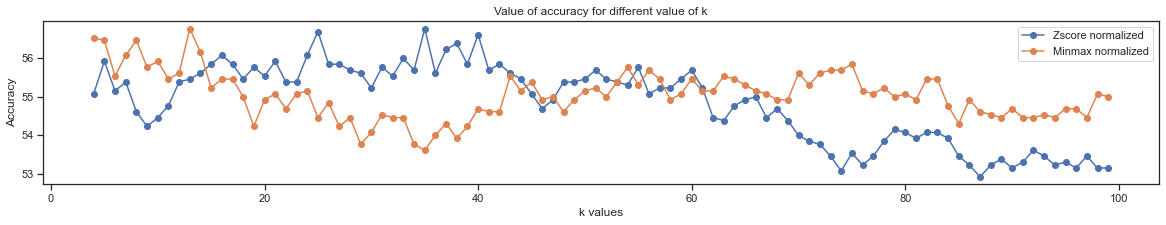

In [31]:
# Plotting the graph between different values of 'k' and accuracy
plt.figure(figsize=(20,3))
plt.plot(k_values, wine_zscore_accuracies, marker='o')
plt.plot(k_values, wine_minmax_accuracies, marker='o')

plt.xlabel("k values")
plt.ylabel("Accuracy")
plt.title("Value of accuracy for different value of k")
plt.legend(["Zscore normalized","Minmax normalized"])
plt.show()

In [32]:
# Finding the maximum accuracy
quality_zscore_max_accuracy = max(wine_zscore_accuracies)
quality_minmax_max_accuracy = max(wine_minmax_accuracies)

# Finding the best value of k
quality_zscore_best_k = k_values[wine_zscore_accuracies.index(quality_zscore_max_accuracy)]
quality_minmax_best_k = k_values[wine_minmax_accuracies.index(quality_minmax_max_accuracy)]

print("*** [Quality] Best value of k for zscore = {} ***".format(quality_zscore_best_k))
print("*** [Quality] Best value of k for minmax = {} ***".format(quality_minmax_best_k))

*** [Quality] Best value of k for zscore = 35 ***
*** [Quality] Best value of k for minmax = 13 ***


In [33]:
## Storing the accuracies for different k-values and different weighting parameters
wine_zscore_accuracies_manhattan = []
wine_zscore_accuracies_euclidean = []
wine_minmax_accuracies_manhattan = []
wine_minmax_accuracies_euclidean = []

# Using 'knn_classify' wrapper function defined above
for k in k_values:
    ''' Quality '''
    acc1_m = knn_classify(wine_zscore_X_train, wine_zscore_X_test, wine_zscore_y_train, wine_zscore_y_test,k,"m")
    acc1_e = knn_classify(wine_zscore_X_train, wine_zscore_X_test, wine_zscore_y_train, wine_zscore_y_test,k,"e")
    
    acc2_m = knn_classify(wine_minmax_X_train, wine_minmax_X_test, wine_minmax_y_train, wine_minmax_y_test,k,"m")
    acc2_e = knn_classify(wine_minmax_X_train, wine_minmax_X_test, wine_minmax_y_train, wine_minmax_y_test,k,"e")
    
    wine_zscore_accuracies_manhattan.append(acc1_m)
    wine_zscore_accuracies_euclidean.append(acc1_e)

    wine_minmax_accuracies_manhattan.append(acc2_m)
    wine_minmax_accuracies_euclidean.append(acc2_e)

In [34]:
# Multiplying accuracies by 100 for better comparison
wine_zscore_accuracies_manhattan = [x*100 for x in wine_zscore_accuracies_manhattan] 
wine_zscore_accuracies_euclidean = [x*100 for x in wine_zscore_accuracies_euclidean] 
wine_minmax_accuracies_manhattan = [x*100 for x in wine_minmax_accuracies_manhattan] 
wine_minmax_accuracies_euclidean = [x*100 for x in wine_minmax_accuracies_euclidean]

*** Plot for Zscore normalized values (Quality) ***


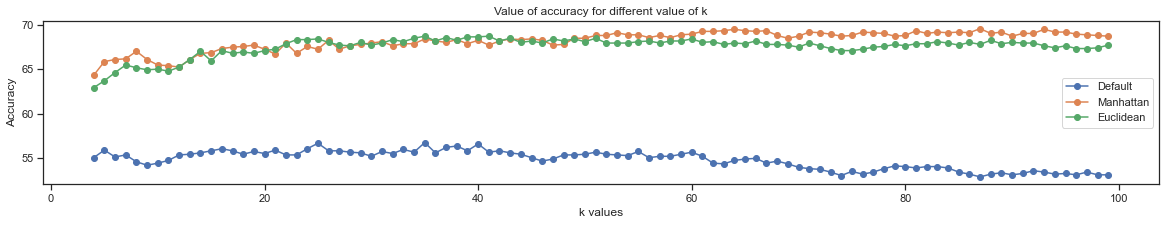

*** Plot for Minmax normalized values (Quality) ***


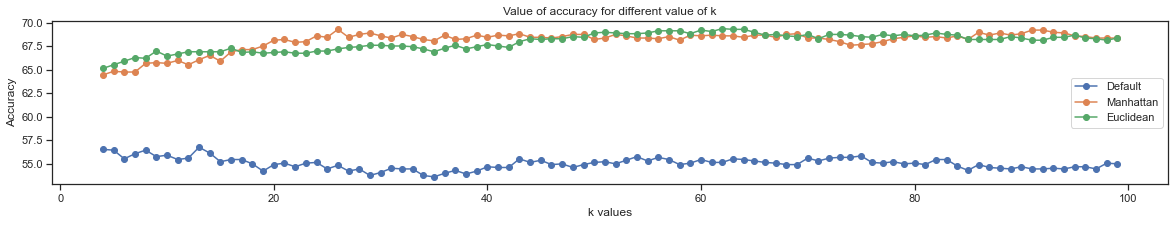

In [35]:
# Creating a function to create the plots
def accuracy_plot(default,manhattan,euclidean):
    plt.figure(figsize=(20,3))
    plt.plot(k_values, default, label='Default', marker='o')
    plt.plot(k_values, manhattan, label="Manhattan", marker='o')
    plt.plot(k_values, euclidean, label="Euclidean", marker='o')

    plt.xlabel("k values")
    plt.ylabel("Accuracy")
    plt.title("Value of accuracy for different value of k")
    plt.legend(["Default","Manhattan","Euclidean"])
    plt.show()

print("*** Plot for Zscore normalized values (Quality) ***")
accuracy_plot(wine_zscore_accuracies,wine_zscore_accuracies_manhattan,wine_zscore_accuracies_euclidean)
print("*** Plot for Minmax normalized values (Quality) ***")
accuracy_plot(wine_minmax_accuracies,wine_minmax_accuracies_manhattan,wine_minmax_accuracies_euclidean)

In [36]:
'''
    Finding the maximum accuracy
'''

zscore_max_accuracy_manhattan = max(wine_zscore_accuracies_manhattan)
zscore_max_accuracy_euclidean = max(wine_zscore_accuracies_euclidean)

print("*** Best accuracy from zscore = {} ***".format(max(quality_zscore_max_accuracy,zscore_max_accuracy_manhattan,zscore_max_accuracy_euclidean)))
print("*** zscore = {} ***".format(quality_zscore_max_accuracy))
print("*** zscore manhattan= {} ***".format(zscore_max_accuracy_manhattan))
print("*** zscore euclidean= {} ***".format(zscore_max_accuracy_euclidean))

print("\n")

minmax_max_accuracy_manhattan = max(wine_minmax_accuracies_manhattan)
minmax_max_accuracy_euclidean = max(wine_minmax_accuracies_euclidean)

print("*** Best accuracy from minmax = {} ***".format(max(quality_minmax_max_accuracy,minmax_max_accuracy_manhattan,minmax_max_accuracy_euclidean)))
print("*** minmax = {} ***".format(quality_minmax_max_accuracy))
print("*** minmax manhattan= {} ***".format(minmax_max_accuracy_manhattan))
print("*** minmax euclidean= {} ***".format(minmax_max_accuracy_euclidean))

'''
    Finding the best value of k
'''
zscore_best_k_manhattan = k_values[wine_zscore_accuracies_manhattan.index(zscore_max_accuracy_manhattan)]
zscore_best_k_euclidean = k_values[wine_zscore_accuracies_euclidean.index(zscore_max_accuracy_euclidean)]

minmax_best_k_manhattan = k_values[wine_minmax_accuracies_manhattan.index(minmax_max_accuracy_manhattan)]
minmax_best_k_euclidean = k_values[wine_minmax_accuracies_euclidean.index(minmax_max_accuracy_euclidean)]

print("\n")
print("*** Best value of k for zscore for manhattan distance metric= {} ***".format(zscore_best_k_manhattan))
print("*** Best value of k for zscore for euclidean distance metric= {} ***".format(zscore_best_k_euclidean))

print("*** Best value of k for minmax for manhattan distance metric= {} ***".format(minmax_best_k_manhattan))
print("*** Best value of k for minmax for euclidean distance metric= {} ***".format(minmax_best_k_euclidean))

*** Best accuracy from zscore = 69.53846153846153 ***
*** zscore = 56.769230769230774 ***
*** zscore manhattan= 69.53846153846153 ***
*** zscore euclidean= 68.6923076923077 ***


*** Best accuracy from minmax = 69.38461538461539 ***
*** minmax = 56.769230769230774 ***
*** minmax manhattan= 69.3076923076923 ***
*** minmax euclidean= 69.38461538461539 ***


*** Best value of k for zscore for manhattan distance metric= 87 ***
*** Best value of k for zscore for euclidean distance metric= 35 ***
*** Best value of k for minmax for manhattan distance metric= 26 ***
*** Best value of k for minmax for euclidean distance metric= 62 ***


In [37]:
wine_raw = wine_minmax
wine_best_k = 26
wine_best_weight = "m"

*** Quality ***


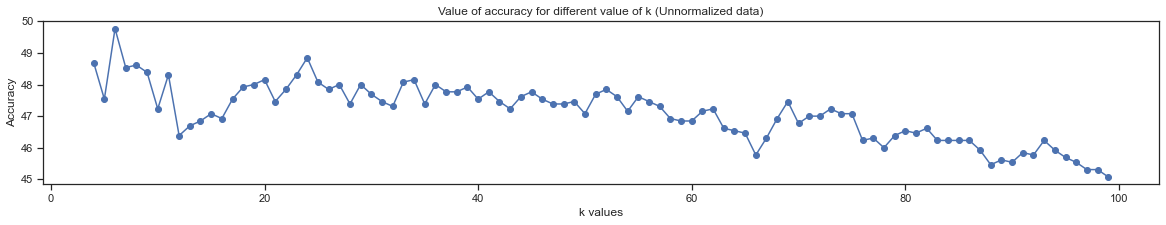

*** Plot for Unnormalized values ***


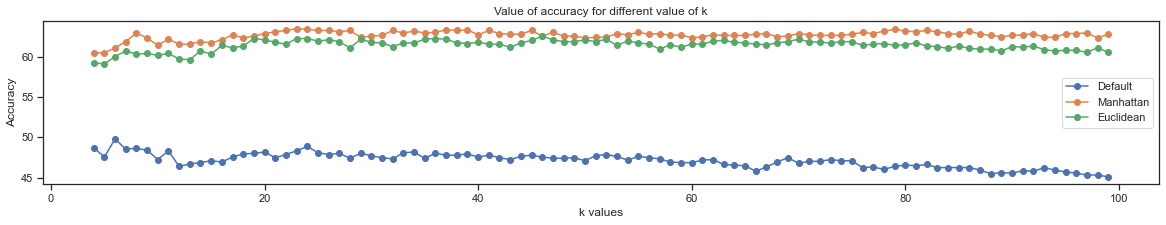

In [38]:
print("*** Quality ***")
# Splitting unnormalized data into training and testing set
wine_unnormal_X_train, wine_unnormal_X_test, wine_unnormal_y_train, wine_unnormal_y_test = generate_train_test_splits(wine_dataframe_unnormal,wine_target)
# Calculating accuracy
wine_unnormal_accuracy = knn_classify(wine_unnormal_X_train, wine_unnormal_X_test, wine_unnormal_y_train, wine_unnormal_y_test)

wine_unnormal_accuracies = []
for k in k_values:
    acc1 = knn_classify(wine_unnormal_X_train, wine_unnormal_X_test, wine_unnormal_y_train, wine_unnormal_y_test,k)
    wine_unnormal_accuracies.append(acc1)    
    
wine_unnormal_accuracies = [x*100 for x in wine_unnormal_accuracies]
plt.figure(figsize=(20,3))
plt.plot(k_values, wine_unnormal_accuracies, marker='o')
plt.xlabel("k values")
plt.ylabel("Accuracy")
plt.title("Value of accuracy for different value of k (Unnormalized data)")
plt.show()

# Trying manhatten and euclidean metrics for unnormalized data
wine_unnormal_accuracies_manhattan = []
wine_unnormal_accuracies_euclidean = []

for k in k_values:
    acc1_m = knn_classify(wine_unnormal_X_train, wine_unnormal_X_test, wine_unnormal_y_train, wine_unnormal_y_test,k,"m")
    acc1_e = knn_classify(wine_unnormal_X_train, wine_unnormal_X_test, wine_unnormal_y_train, wine_unnormal_y_test,k,"e")
    wine_unnormal_accuracies_manhattan.append(acc1_m)
    wine_unnormal_accuracies_euclidean.append(acc1_e)

wine_unnormal_accuracies_manhattan = [x*100 for x in wine_unnormal_accuracies_manhattan] 
wine_unnormal_accuracies_euclidean = [x*100 for x in wine_unnormal_accuracies_euclidean]

print("*** Plot for Unnormalized values ***")
accuracy_plot(wine_unnormal_accuracies,wine_unnormal_accuracies_manhattan,wine_unnormal_accuracies_euclidean)

In [39]:
''' Quality '''
print("*** Quality ***")
# Finding the maximum accuracy
unnormal_max_accuracy = max(wine_unnormal_accuracies)
unnormal_max_accuracy_manhattan = max(wine_unnormal_accuracies_manhattan)
unnormal_max_accuracy_euclidean = max(wine_unnormal_accuracies_euclidean)

print("*** Best accuracy from unnormalized data = {} ***".format(max(unnormal_max_accuracy,unnormal_max_accuracy_manhattan,unnormal_max_accuracy_euclidean)))

# Finding the best value of k
unnormal_best_k = k_values[wine_unnormal_accuracies.index(unnormal_max_accuracy)]
unnormal_best_k_manhattan = k_values[wine_unnormal_accuracies_manhattan.index(unnormal_max_accuracy_manhattan)]
unnormal_best_k_euclidean = k_values[wine_unnormal_accuracies_euclidean.index(unnormal_max_accuracy_euclidean)]

print("*** Best value of k for unnormalized distance metric= {} ***".format(unnormal_best_k))
print("*** Best value of k for unnormalized for manhattan distance metric= {} ***".format(unnormal_best_k_manhattan))
print("*** Best value of k for unnormalized for euclidean distance metric= {} ***".format(unnormal_best_k_euclidean))

*** Quality ***
*** Best accuracy from unnormalized data = 63.46153846153846 ***
*** Best value of k for unnormalized distance metric= 6 ***
*** Best value of k for unnormalized for manhattan distance metric= 23 ***
*** Best value of k for unnormalized for euclidean distance metric= 46 ***


Conclusion: <br><br>
Best accuracy from zscore = 68.61538461538461 <br>
Best accuracy from minmax = 68.6923076923077<br>
Best accuracy from unnormalized data = 61.15384615384616<br>

# 1. Representation Learning 

What: Set of techniques that allows a system to automatically discover the representations needed for feature detection or classification from raw data. https://en.wikipedia.org/wiki/Feature_learning

Why: The data can sometimes be so large that it becomes computationally expensive to perform operations and store data. Hence the need to reduce dimensionality.

How: We use PCA, LDA and t-SNE algorithms

## 1.1. PCA, LDA, t-SNE plots

### 1.1.0. Functions

In [40]:
def run_pca(df,n=2):
    pca = PCA(n_components=n)
    principalComponents_trained = pca.fit_transform(df)
    return principalComponents_trained,pca

def run_lda(df_X,df_y,n=2):
    lda = LinearDiscriminantAnalysis(n_components=n)
    ldaComponents_trained = lda.fit_transform(df_X,df_y)
    return ldaComponents_trained

def run_tsne(df,n=2):
    t_sne = TSNE(n_components=n,init='random')
    tsneComponents_trained = t_sne.fit_transform(df)
    return tsneComponents_trained

def draw_plot(df_components,df_target,title):
    plt.figure(figsize=(10,10))
    colors = sns.color_palette(None, df_target.nunique()) # Generate random colors to use in the plot
    lw = 1 # Linewidth
    target_names = df_target.unique()

    for color, target_name in zip(colors, target_names):
        plt.scatter(df_components[df_target == target_name,0], df_components[df_target == target_name,1], color=color, alpha=.8, lw=lw,label=target_name)
        plt.legend(loc='best', shadow=False, scatterpoints=1)
        plt.title(title+' of Abalone')
    

### 1.1.1. Abalone

In [41]:
df_abalone_target = abalone_zscore['Rings']

PCA<br>
We drop the 'Sex' feature because it is recommended to remove discrete value variables for PCA

In [42]:
df_abalone_prePCA = abalone_zscore.drop(columns=['Rings','Sex'])

principalComponents_trained_abalone, pca_object = run_pca(df_abalone_prePCA)

Text(0, 0.5, 'PCA2')

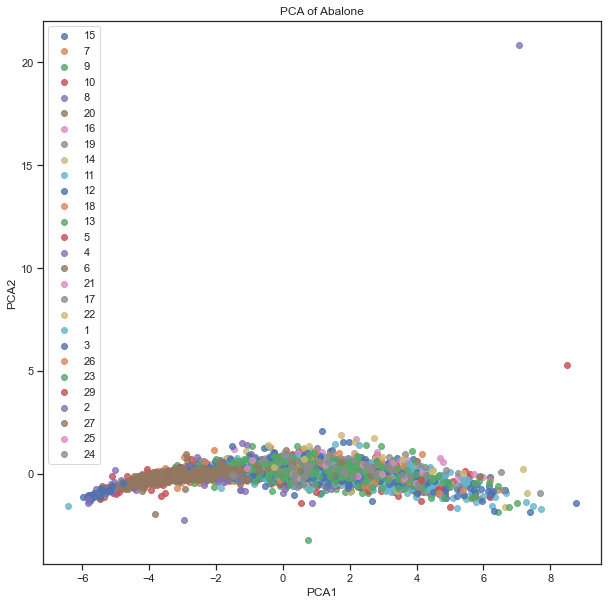

In [43]:
# PCA plot
draw_plot(principalComponents_trained_abalone, df_abalone_target,"PCA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

The graph for Abalone PCA makes just one cluster and shows the variability of first 2 dimensions in a scatter plot. They are highly correlated fields and hence makes just one cluster.The explained variance in PCA 2D plot for abalone dataset shows that the first principal component is a siginificant feature because it explains about 93% of the dataset.
The fact that it goes from lower to higher and then back to lower shows the variance of values in the data. It also point out s the outliers regarding the output target.

LDA<br>

We drop the 'Rings' feature because it is a target value.

In [44]:
df_abalone_preLDA = abalone_zscore.drop(columns=['Rings'])

ldaComponents_trained_abalone = run_lda(df_abalone_preLDA,df_abalone_target)

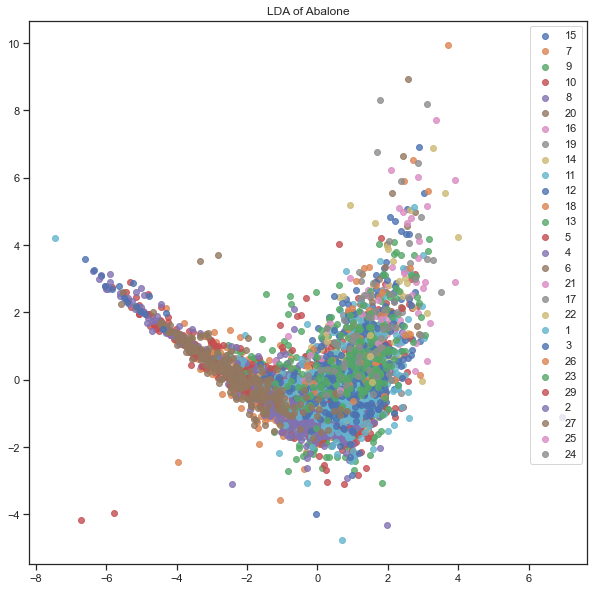

In [45]:
# LDA plot
draw_plot(ldaComponents_trained_abalone, df_abalone_target,"LDA")

When LDA is performed, the explained variance of the first component is approximately 70% in comparison to the approx 23% for the second component, making it yet more significant than component 2.
This plot also shows the dimensionality reduction. This graph goes from Higher to lower and back to higher values. The variance is more and so but the separability of data is very less as it forms one big cluster.

t-SNE

In [46]:
df_abalone_preTSNE = abalone_zscore.drop(columns=['Rings'])

tsneComponents_trained_abalone = run_tsne(df_abalone_preTSNE)

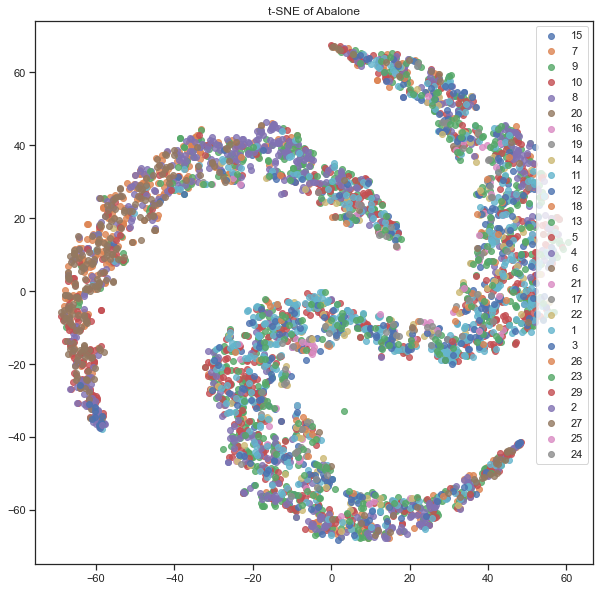

In [47]:
# t-SNE plot
draw_plot(tsneComponents_trained_abalone, df_abalone_target,"t-SNE")

The tSNE plots show the labels (viz. Rings for abalone). t-SNE is able to better differentiate the dataset into different clusters which is more clearer than PCA and LDA
The shape of the graph for abalone shows an S-curve shape.

### 1.1.2. Wine

In [48]:
df_wine_target = wine_minmax['quality']

PCA<br>
We drop the 'color' feature because it is recommended to remove discrete value variables for PCA

In [49]:
df_wine_prePCA = wine_zscore.drop(columns=['quality','color'])

principalComponents_trained_wine, pca_object = run_pca(df_wine_prePCA)

Text(0.5, 1.0, 'PCA of Wine')

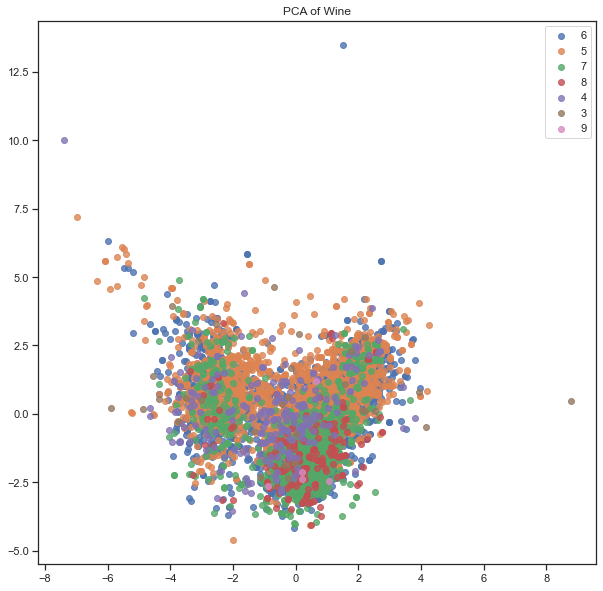

In [50]:
# PCA plot
draw_plot(principalComponents_trained_wine, df_wine_target,"PCA")
plt.title("PCA of Wine")

This plot shows just one big cluster and hence shows that it's variance the fact that it has highly correlated fields. It also has a lot of dimensions and hence PCA makes a big cluster.

LDA

In [51]:
df_wine_preLDA = wine_zscore.drop(columns=['quality'])

ldaComponents_trained_wine = run_lda(df_wine_preLDA,df_wine_target)

Text(0.5, 1.0, 'LDA of Wine')

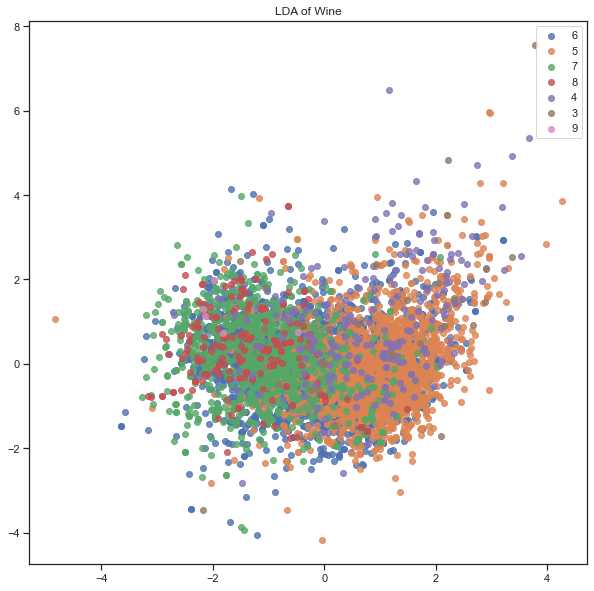

In [52]:
# LDA plot
draw_plot(ldaComponents_trained_wine, df_wine_target,"LDA")
plt.title("LDA of Wine")

It's very difficult to see the separability in the LDA plot which shows that it is a highly correlated dataset. 

t-SNE

In [53]:
df_wine_preTSNE = wine_zscore.drop(columns=['quality'])

tsneComponents_trained_wine = run_tsne(df_wine_preTSNE)

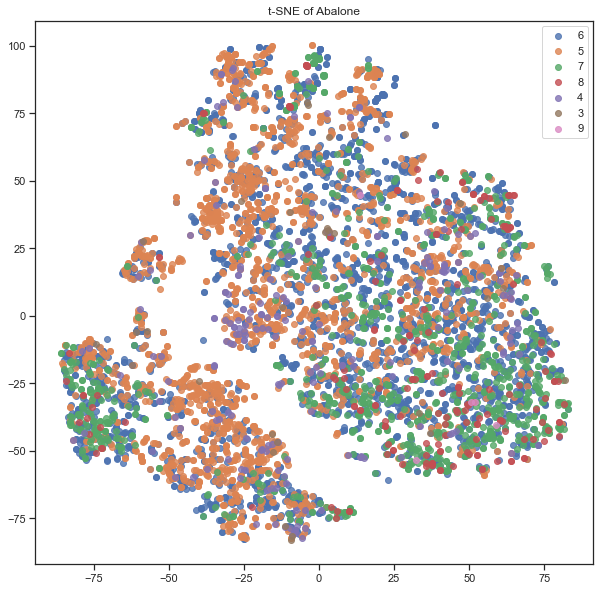

In [54]:
# t-SNE plot
draw_plot(tsneComponents_trained_wine, df_wine_target,"t-SNE")

The tSNE plots show the labels (viz. Quality for wine).
Here t-SNE graph does not make separate clusters and even if it does something, it's not well defined. The visualization for t-SNE Wine dataset is not very clear as compared to Abalone t-SNE.

## 1.2. Scree plot

What: Scree plot is a line plot of the eigenvalues of factors or principal components in an analysis. https://en.wikipedia.org/wiki/Scree_plot#:~:text=In%20multivariate%20statistics%2C%20a%20scree,principal%20component%20analysis%20(PCA).

Why: To analyze how many dimensions can give the best representation of original data

How: We use the method 'explained_variance_ratio_' to extract variance represented by principal components

### 1.2.1. Abalone

total variance 0.9999999999999997


Text(0.5, 1.0, 'Scree plot')

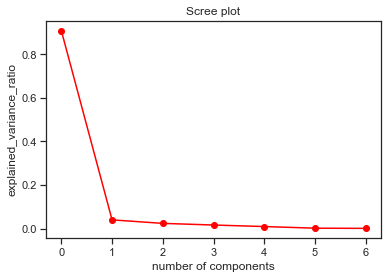

In [55]:
df_abalone_prePCA = abalone_zscore.drop(columns=['Rings','Sex'])

# Perform PCA using all dimensions
principalComponents_trained_abalone, pca_object = run_pca(df_abalone_prePCA,len(df_abalone_prePCA.columns))

# Plot the curve of variance represented by each principal component
plt.plot(pca_object.explained_variance_ratio_, marker = 'o',color='red')
scores=pca_object.explained_variance_ratio_
s=scores.sum()
print('total variance',s)
plt.xlabel('number of components')
plt.ylabel('explained_variance_ratio')
plt.title("Scree plot")


In [56]:
arr=[]
for x in range(1,len(df_abalone_prePCA.columns)+1):
    x="%s" %x
    a = 'PC' + x
    arr.append(a)

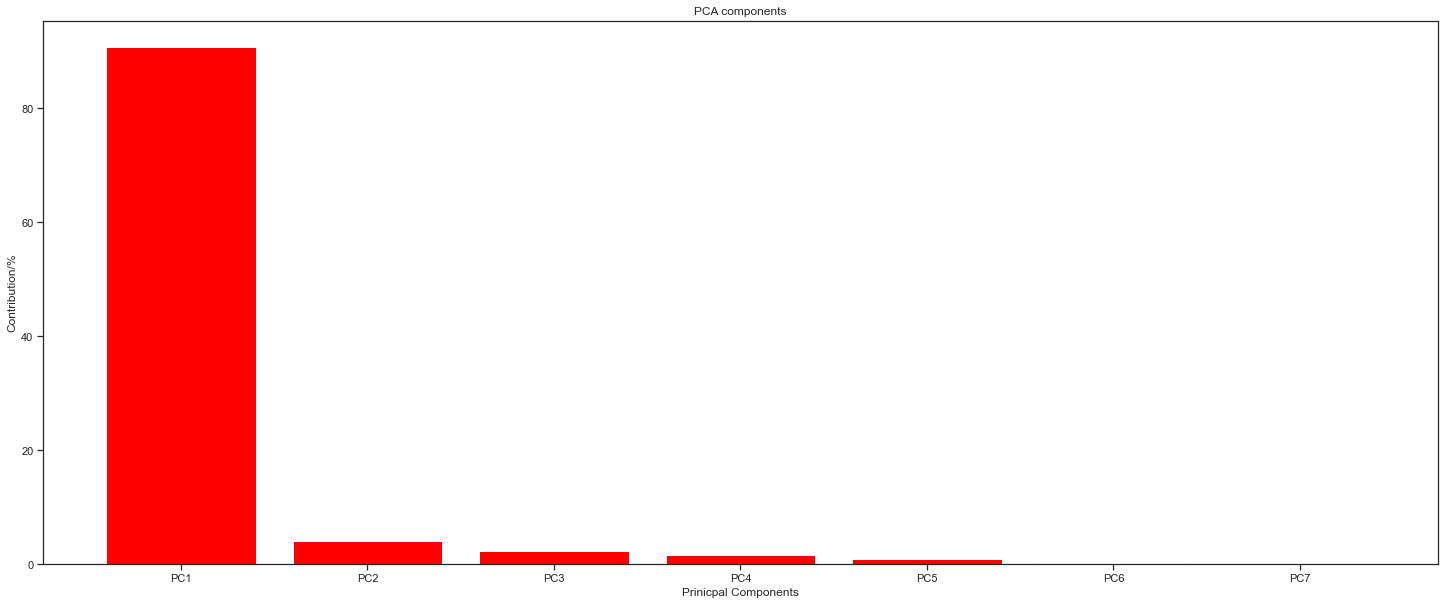

In [57]:
# Variances represented as bar plot
plt.figure(figsize=(25,10))
plt.bar(arr, pca_object.explained_variance_ratio_*100 , color ='red')
plt.xlabel("Prinicpal Components")
plt.ylabel("Contribution/%")
plt.title("PCA components")
plt.show()

In [58]:
print(pca_object.explained_variance_)
print(pca_object.explained_variance_ratio_*100)
print(pca_object.explained_variance_ratio_.cumsum())

[6.35663385 0.27949928 0.16738475 0.11409916 0.0646694  0.01273114
 0.00665866]
[90.78731479  3.9918909   2.3906382   1.62959779  0.92362741  0.18182994
  0.09510098]
[0.90787315 0.94779206 0.97169844 0.98799442 0.99723069 0.99904899
 1.        ]


### 1.2.1. Wine

total variance 1.0000000000000002


Text(0.5, 1.0, 'Scree plot')

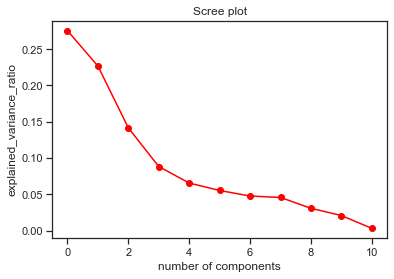

In [59]:
df_wine_prePCA = wine_zscore.drop(columns=['quality','color'])

# Perform PCA using all dimensions
principalComponents_trained_wine, pca_object = run_pca(df_wine_prePCA,len(df_wine_prePCA.columns))

# Plot the curve of variance represented by each principal component
plt.plot(pca_object.explained_variance_ratio_, marker = 'o',color='red')
scores=pca_object.explained_variance_ratio_
s=scores.sum()
print('total variance',s)
plt.xlabel('number of components')
plt.ylabel('explained_variance_ratio')
plt.title("Scree plot")


In [60]:
arr=[]
for x in range(1,len(df_wine_prePCA.columns)+1):
    x="%s" %x
    a = 'PC' + x
    arr.append(a)

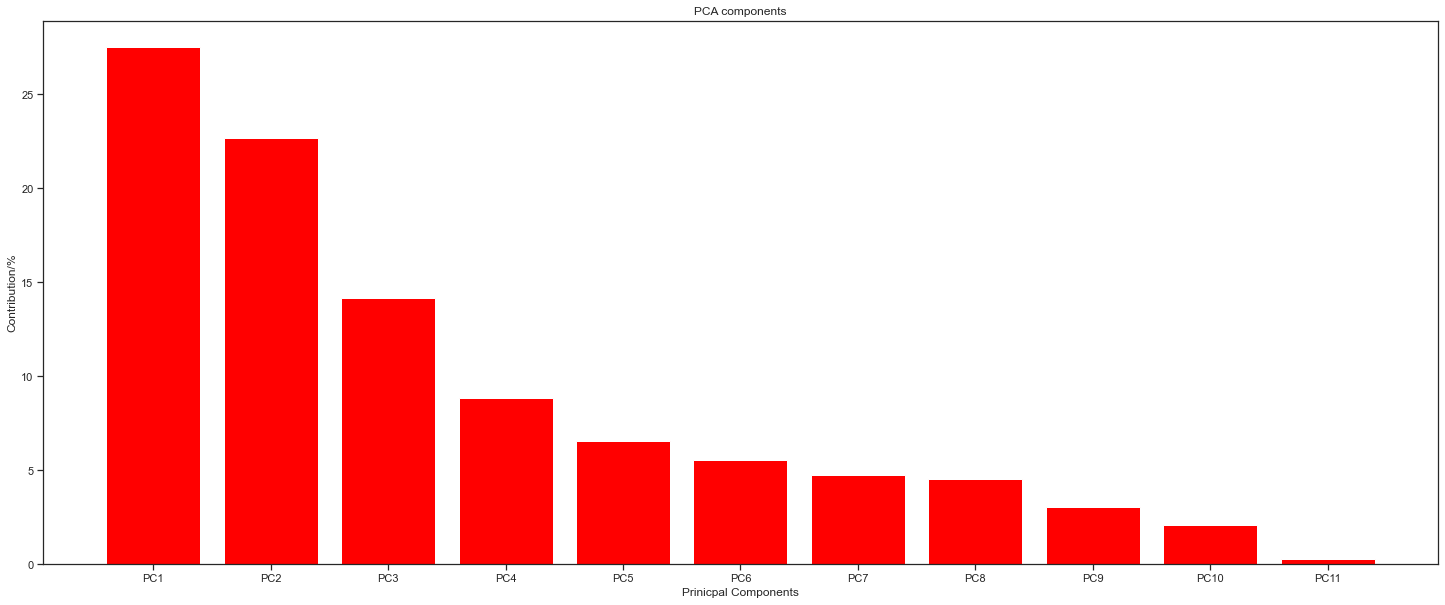

In [61]:
# Variances represented as bar plot
plt.figure(figsize=(25,10))
plt.bar(arr, pca_object.explained_variance_ratio_*100 , color ='red')
plt.xlabel("Prinicpal Components")
plt.ylabel("Contribution/%")
plt.title("PCA components")
plt.show()

In [62]:
print(pca_object.explained_variance_)
print(pca_object.explained_variance_ratio_*100)
print(pca_object.explained_variance_ratio_.cumsum())

[3.03033507 2.49420993 1.55658654 0.97070149 0.71998573 0.6074052
 0.5232393  0.50158749 0.33707593 0.22773082 0.03283586]
[27.54426044 22.6711457  14.14860866  8.82320072  6.54431742  5.52101555
  4.75598876  4.55918446  3.06385496  2.0699615   0.29846184]
[0.2754426  0.50215406 0.64364015 0.73187216 0.79731533 0.85252548
 0.90008537 0.94567722 0.97631577 0.99701538 1.        ]


## 1.3. KNN comparison with PCA

What: This is the stage where we test the effect of PCA on KNN classifier

Why: To reduce the dimensionality of the dataset and use those results

How: We run the KNN classifier on datasets with dimensions starting from 2 to D(original no. of dimensions)

### 1.3.1. Abalone

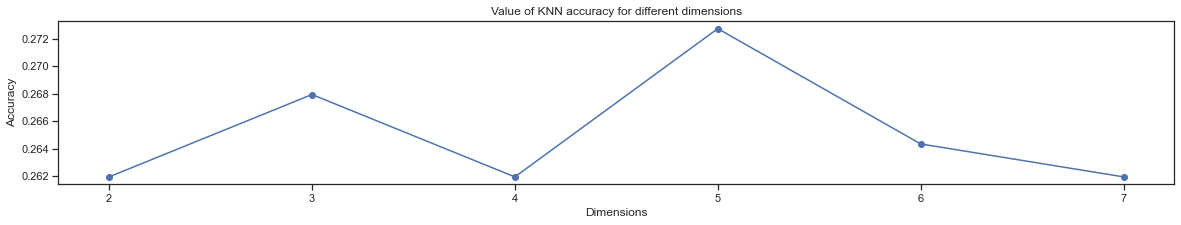

*** [PCA] Best number of dimension = 5 ***
*** [PCA] Best accuracy = 0.2727272727272727 ***


In [63]:
# Using raw dataset for abalone
abalone_pca_df = abalone_raw.drop(columns=['Rings','Sex'])

abalone_pca_accuracies = []

# Increment dimesnions from 2 to D(original no.)
for i in range (2, len(abalone_pca_df.columns)+1):
    principalComponents_trained_abalone, pca_object = run_pca(abalone_pca_df,i)
    principalDf_abalone = pd.DataFrame(data = principalComponents_trained_abalone, columns = ['PC'+str(x) for x in range(1,i+1)])
    principalDf_abalone = pd.concat([principalDf_abalone,df_abalone_target],axis=1)
    
    abalone_X_train, abalone_X_test, abalone_y_train, abalone_y_test = generate_train_test_splits(principalDf_abalone,abalone_target)
    acc = knn_classify(abalone_X_train, abalone_X_test, abalone_y_train, abalone_y_test,abalone_best_k,abalone_best_weight)
    abalone_pca_accuracies.append(acc)

# Plot the curve for dimensions v/s accuracy
plt.figure(figsize=(20,3))
plt.plot(np.arange(2,len(abalone_pca_df.columns)+1), abalone_pca_accuracies, marker='o')
plt.title("Value of KNN accuracy for different dimensions")
plt.xlabel("Dimensions")
plt.ylabel("Accuracy")
plt.show()

abalone_pca_max_accuracy = max(abalone_pca_accuracies)
abalone_pca_best_dim = abalone_pca_accuracies.index(abalone_pca_max_accuracy) + 2
print("*** [PCA] Best number of dimension = {} ***".format(abalone_pca_best_dim))
print("*** [PCA] Best accuracy = {} ***".format(abalone_pca_max_accuracy))

In [64]:
# Preserve best dataset
principalComponents_trained_abalone, pca_object = run_pca(abalone_pca_df, abalone_pca_best_dim)
abalone_pca = pd.DataFrame(data = principalComponents_trained_abalone, columns = ['PC'+str(x) for x in range(1,abalone_pca_best_dim+1)])

# Normalize
cols = list(abalone_pca.columns)
cols.append("Rings")
scaler_minmax = MinMaxScaler()
features_data_x = abalone_pca.values
target_y = df_abalone_target.values
X_minmax = scaler_minmax.fit_transform(features_data_x)
abalone_pca = pd.DataFrame(data=np.column_stack((X_minmax, target_y)),columns=cols)

abalone_pca

PC1       PC2       PC3       PC4       PC5  Rings
0     0.312603  0.234356  0.288616  0.499012  0.115334   15.0
1     0.192208  0.363140  0.303166  0.474048  0.130050    7.0
2     0.385672  0.133879  0.315993  0.459847  0.129182    9.0
3     0.312521  0.259253  0.304889  0.461689  0.145886   10.0
4     0.176361  0.387981  0.297897  0.481667  0.128011    7.0
...        ...       ...       ...       ...       ...    ...
4172  0.462138  0.219738  0.281689  0.334191  0.145662   11.0
4173  0.474549  0.240729  0.256218  0.462117  0.107797   10.0
4174  0.540327  0.317828  0.261545  0.383904  0.168898    9.0
4175  0.535068  0.232351  0.230994  0.442502  0.117543   10.0
4176  0.750156  0.521535  0.229241  0.644317  0.126730   12.0

[4177 rows x 6 columns]

Comments: We found that the best no. of principal components for abalone dataset is 5. The no. of prinicpal components initially increase as the variance cover increases but then accuracy starts decreasing before reaching the maximum (which is at 5 components).

### 1.3.2. Wine

In [65]:
# Shuffle the dataset
wine_raw = wine_raw.sample(frac=1).reset_index(drop=True)
df_wine_target = wine_raw['quality']

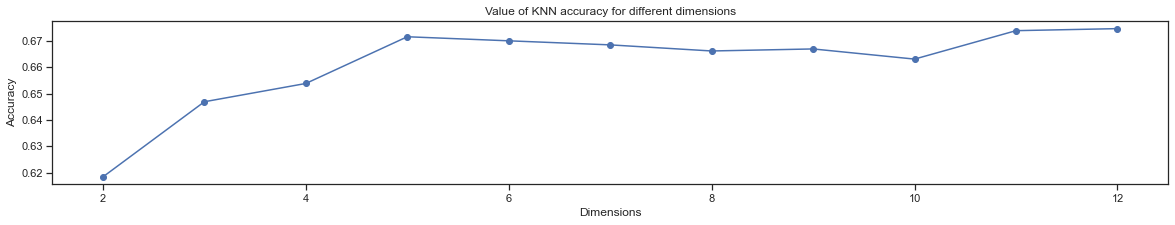

*** [PCA] Best number of dimension = 12 ***
*** [PCA] Best accuracy = 0.6746153846153846 ***


In [66]:
# Using raw dataset for abalone
wine_pca_df = wine_raw.drop(columns=['quality'])

wine_pca_accuracies = []

# Increment dimesnions from 2 to D(original no.)
for i in range (2, len(wine_pca_df.columns)+1):
    principalComponents_trained_wine, pca_object = run_pca(wine_pca_df,i)
    principalDf_wine = pd.DataFrame(data = principalComponents_trained_wine, columns = ['PC'+str(x) for x in range(1,i+1)])
    principalDf_wine = pd.concat([principalDf_wine,df_wine_target],axis=1)
    
    wine_X_train, wine_X_test, wine_y_train, wine_y_test = generate_train_test_splits(principalDf_wine,wine_target)
    acc = knn_classify(wine_X_train, wine_X_test, wine_y_train, wine_y_test,wine_best_k,wine_best_weight)
    wine_pca_accuracies.append(acc)

# Plot the curve for dimensions v/s accuracy
plt.figure(figsize=(20,3))
plt.plot(np.arange(2,len(wine_pca_df.columns)+1), wine_pca_accuracies, marker='o')
plt.title("Value of KNN accuracy for different dimensions")
plt.xlabel("Dimensions")
plt.ylabel("Accuracy")
plt.show()

wine_pca_max_accuracy = max(wine_pca_accuracies)
wine_pca_best_dim = wine_pca_accuracies.index(wine_pca_max_accuracy) + 2
print("*** [PCA] Best number of dimension = {} ***".format(wine_pca_best_dim))
print("*** [PCA] Best accuracy = {} ***".format(wine_pca_max_accuracy))

In [67]:
# Preserve best dataset
principalComponents_trained_wine, pca_object = run_pca(wine_pca_df, wine_pca_best_dim)
wine_pca = pd.DataFrame(data = principalComponents_trained_wine, columns = ['PC'+str(x) for x in range(1,wine_pca_best_dim+1)])

# Normalize
cols = list(wine_pca.columns)
cols.append("quality")
scaler_minmax = MinMaxScaler()
features_data_x = wine_pca.values
target_y = df_wine_target.values
X_minmax = scaler_minmax.fit_transform(features_data_x)
wine_pca = pd.DataFrame(data=np.column_stack((X_minmax, target_y)),columns=cols)

wine_pca

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0     0.128383  0.244651  0.414620  0.401275  0.312981  0.350071  0.285320   
1     0.183459  0.318271  0.442155  0.117952  0.258194  0.611287  0.229156   
2     0.133060  0.158552  0.362509  0.516371  0.401336  0.505859  0.252254   
3     0.127252  0.569098  0.411336  0.444419  0.265499  0.389283  0.175328   
4     0.092766  0.196567  0.429429  0.605044  0.344446  0.450519  0.153271   
...        ...       ...       ...       ...       ...       ...       ...   
6492  0.164755  0.475578  0.339781  0.445031  0.119493  0.491836  0.262768   
6493  0.164518  0.350560  0.355514  0.427130  0.216317  0.509025  0.349646   
6494  0.126338  0.294781  0.362343  0.364068  0.352573  0.392699  0.268622   
6495  0.125729  0.716630  0.459722  0.592795  0.370937  0.487068  0.163650   
6496  0.145640  0.421504  0.487812  0.446871  0.258931  0.415636  0.332425   

           PC8       PC9      PC10      PC11      PC12  quality  
0     0.328664  0.304399  0.225285  0.283910  0.199585      5.0  
1     0.290701  0.344219  0.237317  0.348900  0.194595      4.0  
2     0.352220  0.325912  0.256564  0.278254  0.174989      5.0  
3     0.244886  0.360220  0.255984  0.310203  0.217052      6.0  
4     0.184728  0.574336  0.160074  0.289771  0.209145      6.0  
...        ...       ...       ...       ...       ...      ...  
6492  0.241163  0.354756  0.226198  0.344822  0.212694      7.0  
6493  0.241086  0.353919  0.166224  0.241919  0.250358      5.0  
6494  0.185253  0.318517  0.222281  0.313247  0.224478      5.0  
6495  0.203474  0.373233  0.261148  0.303019  0.232734      7.0  
6496  0.235871  0.289639  0.198286  0.275001  0.221666      5.0  

[6497 rows x 13 columns]

Comments: We found that the best no. of principal components for wine dataset is 11. The no. of prinicpal components initially increase as the variance cover increases but then accuracy starts decreasing before reaching a local maxima (which is at 5 components). The accuracy decreases for 6 but then again starts to increase. Eventually reaching maximum value at 11.

## 1.4. KNN comparison with LDA

What: This is the stage where we test the effect of LDA on KNN classifier. LDA takes in the labels as well.

Why: To reduce the dimensionality of the dataset and use those results.

How: We run the KNN classifier on datasets with dimensions starting from 2. But we cannot go till D(original no. of dimensions). LDA can go till min(features, n_classes - 1)

### 1.4.1. Abalone

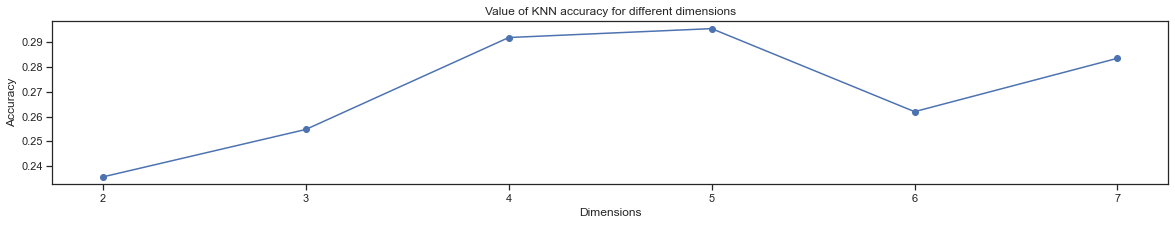

*** [LDA] Best number of dimension = 5 ***
*** [LDA] Best accuracy = 0.29545454545454547 ***


In [68]:
abalone_lda_accuracies = []

# Increment dimesnions from 2 to D(original no.)
for i in range (2, len(abalone_pca_df.columns)+1):
    ldaComponents_trained_abalone = run_lda(abalone_pca_df,df_abalone_target,i)
    ldaDf_abalone = pd.DataFrame(data = ldaComponents_trained_abalone, columns = ['LDA'+str(x) for x in range(1,i+1)])
    ldaDf_abalone = pd.concat([ldaDf_abalone,df_abalone_target],axis=1)
    
    abalone_X_train, abalone_X_test, abalone_y_train, abalone_y_test = generate_train_test_splits(ldaDf_abalone,abalone_target)
    acc = knn_classify(abalone_X_train, abalone_X_test, abalone_y_train, abalone_y_test,abalone_best_k,"e")
    abalone_lda_accuracies.append(acc)

# Plot the curve for dimensions v/s accuracy
plt.figure(figsize=(20,3))
plt.plot(np.arange(2,len(abalone_pca_df.columns)+1), abalone_lda_accuracies, marker='o')
plt.title("Value of KNN accuracy for different dimensions")
plt.xlabel("Dimensions")
plt.ylabel("Accuracy")
plt.show()

abalone_lda_max_accuracy = max(abalone_lda_accuracies)
abalone_lda_best_dim = abalone_lda_accuracies.index(abalone_lda_max_accuracy) + 2
print("*** [LDA] Best number of dimension = {} ***".format(abalone_lda_best_dim))
print("*** [LDA] Best accuracy = {} ***".format(abalone_lda_max_accuracy))

In [69]:
# Preserve best dataset
ldaComponents_trained_abalone = run_lda(abalone_pca_df, df_abalone_target, abalone_lda_best_dim)
abalone_lda = pd.DataFrame(data = ldaComponents_trained_abalone, columns = ['LDA'+str(x) for x in range(1,abalone_lda_best_dim+1)])

# Normalize
cols = list(abalone_lda.columns)
cols.append("Rings")
scaler_minmax = MinMaxScaler()
features_data_x = abalone_lda.values
target_y = df_abalone_target.values
X_minmax = scaler_minmax.fit_transform(features_data_x)
abalone_lda = pd.DataFrame(data=np.column_stack((X_minmax, target_y)),columns=cols)

# abalone_lda = pd.concat([abalone_lda,df_abalone_target],axis=1)
abalone_lda

LDA1      LDA2      LDA3      LDA4      LDA5  Rings
0     0.445853  0.307404  0.559614  0.540530  0.462895   15.0
1     0.340505  0.346354  0.550324  0.535154  0.457676    7.0
2     0.550743  0.306631  0.608844  0.559746  0.454616    9.0
3     0.457944  0.330091  0.551380  0.566540  0.416559   10.0
4     0.319040  0.359324  0.543199  0.553085  0.467851    7.0
...        ...       ...       ...       ...       ...    ...
4172  0.561154  0.281729  0.519228  0.580015  0.368370   11.0
4173  0.527787  0.262529  0.534422  0.517368  0.502017   10.0
4174  0.570796  0.297163  0.486315  0.585816  0.422658    9.0
4175  0.555728  0.220371  0.481394  0.501100  0.436134   10.0
4176  0.555918  0.347403  0.391999  0.499526  0.634488   12.0

[4177 rows x 6 columns]

Comments: We found that the best no. of principal components for abalone dataset is 5. The no. of prinicpal components initially increase as the variance cover increases but then accuracy starts decreasing before reaching the maximum (which is at 5 components).<br><br>
abalone_lda gives better accuracy than abalone_pca

### 1.4.2. Wine

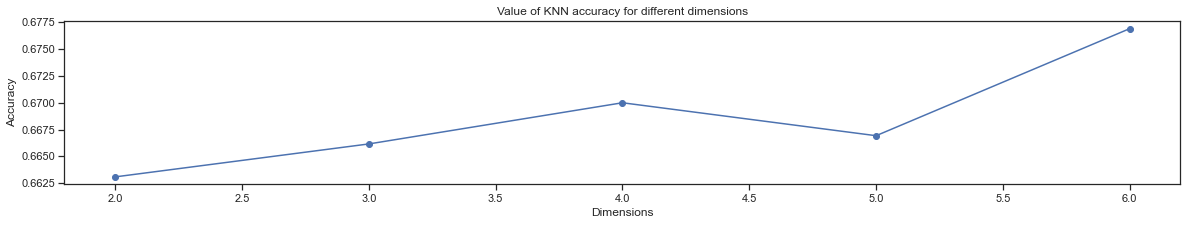

*** [LDA] Best number of dimension = 6 ***
*** [LDA] Best accuracy = 0.676923076923077 ***


In [70]:
wine_lda_accuracies = []

# Increment dimesnions from 2 to D(original no.)
for i in range (2, min(df_wine_target.nunique(),(len(wine_pca_df.columns)+1))):
    ldaComponents_trained_wine = run_lda(wine_pca_df,df_wine_target,i)
    ldaDf_wine = pd.DataFrame(data = ldaComponents_trained_wine, columns = ['LDA'+str(x) for x in range(1,i+1)])
    ldaDf_wine = pd.concat([ldaDf_wine,df_wine_target],axis=1)
    
    wine_X_train, wine_X_test, wine_y_train, wine_y_test = generate_train_test_splits(ldaDf_wine,wine_target)
    acc = knn_classify(wine_X_train, wine_X_test, wine_y_train, wine_y_test,wine_best_k,"e")
    wine_lda_accuracies.append(acc)

# Plot the curve for dimensions v/s accuracy
plt.figure(figsize=(20,3))
plt.plot(np.arange(2,min(df_wine_target.nunique(),(len(wine_pca_df.columns)+1))), wine_lda_accuracies, marker='o')
plt.title("Value of KNN accuracy for different dimensions")
plt.xlabel("Dimensions")
plt.ylabel("Accuracy")
plt.show()

wine_lda_max_accuracy = max(wine_lda_accuracies)
wine_lda_best_dim = wine_lda_accuracies.index(wine_lda_max_accuracy) + 2
print("*** [LDA] Best number of dimension = {} ***".format(wine_lda_best_dim))
print("*** [LDA] Best accuracy = {} ***".format(wine_lda_max_accuracy))

In [71]:
# Preserve best dataset
ldaComponents_trained_wine = run_lda(wine_pca_df, df_wine_target, wine_lda_best_dim)
wine_lda = pd.DataFrame(data = ldaComponents_trained_wine, columns = ['LDA'+str(x) for x in range(1,wine_lda_best_dim+1)])

# Normalize
cols = list(wine_lda.columns)
cols.append("quality")
scaler_minmax = MinMaxScaler()
features_data_x = wine_lda.values
target_y = df_wine_target.values
X_minmax = scaler_minmax.fit_transform(features_data_x)
wine_lda = pd.DataFrame(data=np.column_stack((X_minmax, target_y)),columns=cols)

# wine_lda = pd.concat([wine_lda,df_wine_target],axis=1)
wine_lda

LDA1      LDA2      LDA3      LDA4      LDA5      LDA6  quality
0     0.465139  0.717035  0.548064  0.698982  0.369719  0.644135      5.0
1     0.294425  0.426707  0.536804  0.656695  0.370440  0.743786      4.0
2     0.428334  0.653874  0.482242  0.691156  0.347661  0.743293      5.0
3     0.596785  0.678764  0.528837  0.673779  0.382276  0.703920      6.0
4     0.343557  0.735551  0.480395  0.748119  0.405394  0.805044      6.0
...        ...       ...       ...       ...       ...       ...      ...
6492  0.484349  0.585987  0.565698  0.655922  0.315167  0.747457      7.0
6493  0.323703  0.555383  0.618231  0.696486  0.332257  0.671100      5.0
6494  0.331365  0.639072  0.516102  0.689869  0.370902  0.640745      5.0
6495  0.671939  0.616532  0.487138  0.669649  0.357991  0.717063      7.0
6496  0.487168  0.627114  0.572882  0.703226  0.308066  0.637760      5.0

[6497 rows x 7 columns]

Comments: We found that the best no. of principal components for wine dataset is 4. The no. of prinicpal components initially increase as the variance cover increases but then accuracy starts decreasing before reaching the maximum (which is at 4 components).<br><br>
wine_pca gives better accuracy than wine_lda

# 2. Naive Bayes Classifier

What: Naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naive) independence assumptions between the features.

Why: To make predictions over the dataset labels 

How: We use K-Fold Cross validation to choose the best hyper-parameters and then perform Naive Bayes using that parameter. There are 2 variations that we will use: Multinomial Naive Bayes and  Complement Naive Bayes. These methods can be accessed from 'sklearn.naive_bayes'. K-Fold Cross validation can be performed using method 'GridSearchCV' from 'sklearn.model_selection'

## 2.1. Cross validation with Naive Bayes'

### 2.1.0. Functions

In [72]:
def run_naive_bayes(df,target,type=""):
    X_train, X_test, y_train, y_test = generate_train_test_splits(df,target) # Train-Test split

    # Select classifier based upon type
    if type == "Complement":
        nbclassifier = ComplementNB()
        parameters = [{'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}]
    elif type == "Multinomial":
        nbclassifier = MultinomialNB()
        parameters = [{'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}]
    else:
        nbclassifier = GaussianNB()
        parameters = [{'var_smoothing': [1e-10, 1e-9, 1e-5, 1e-3, 1e-1]}]

    # Fit training data
    nbclassifier.fit(X_train, y_train)

    # Cross validation
    cv = KFold(n_splits=5, random_state=0, shuffle=True)
    
    # print(nbclassifier.get_params().keys())
    grid_search = GridSearchCV(estimator = nbclassifier, param_grid = parameters, scoring = 'accuracy', cv = cv, return_train_score=False)
    
    grid_search.fit(X_train, y_train)
    max_accuracy = grid_search.best_score_
    best_params = grid_search.best_params_
    results = grid_search.cv_results_
    return max_accuracy, best_params
    

### 2.1.1. Abalone

In [73]:
# For abalone_raw
abalone_raw_max_accuracy_nbc , abalone_raw_best_params_nbc = run_naive_bayes(abalone_raw, abalone_target, "Complement")
print("*** [Abalone-raw] [Complement NB] Best Accuracy: {} ".format(abalone_raw_max_accuracy_nbc*100))
print("*** [Abalone-raw] [Complement NB] Best Parameters:", abalone_raw_best_params_nbc)
print("\n")
abalone_raw_max_accuracy_nbm , abalone_raw_best_params_nbm = run_naive_bayes(abalone_raw, abalone_target, "Multinomial")
print("*** [Abalone-raw] [Multinomial NB] Best Accuracy: {} ".format(abalone_raw_max_accuracy_nbm*100))
print("*** [Abalone-raw] [Multinomial NB] Best Parameters:", abalone_raw_best_params_nbm)

print("\n\n")
# For abalone_lda
abalone_lda_max_accuracy_nbc , abalone_lda_best_params_nbc = run_naive_bayes(abalone_lda, abalone_target, "Complement")
print("*** [Abalone-lda] [Complement NB] Best Accuracy: {} ".format(abalone_lda_max_accuracy_nbc*100))
print("*** [Abalone-lda] [Complement NB] Best Parameters:", abalone_lda_best_params_nbc)
print("\n")
abalone_lda_max_accuracy_nbm , abalone_lda_best_params_nbm = run_naive_bayes(abalone_lda, abalone_target, "Multinomial")
print("*** [Abalone-lda] [Multinomial NB] Best Accuracy: {} ".format(abalone_lda_max_accuracy_nbm*100))
print("*** [Abalone-lda] [Multinomial NB] Best Parameters:", abalone_lda_best_params_nbm)

*** [Abalone-raw] [Complement NB] Best Accuracy: 17.2999740429455 
*** [Abalone-raw] [Complement NB] Best Parameters: {'alpha': 10.0}


*** [Abalone-raw] [Multinomial NB] Best Accuracy: 21.101518935223723 
*** [Abalone-raw] [Multinomial NB] Best Parameters: {'alpha': 1.0}



*** [Abalone-lda] [Complement NB] Best Accuracy: 23.705414283540545 
*** [Abalone-lda] [Complement NB] Best Parameters: {'alpha': 0.01}


*** [Abalone-lda] [Multinomial NB] Best Accuracy: 16.671947584651328 
*** [Abalone-lda] [Multinomial NB] Best Parameters: {'alpha': 0.01}


### 2.1.1. Wine

In [74]:
# For wine_raw
wine_raw_max_accuracy_nbc , wine_raw_best_params_nbc = run_naive_bayes(wine_raw, wine_target, "Complement")
print("*** [wine-raw] [Complement NB] Best Accuracy: {} ".format(wine_raw_max_accuracy_nbc*100))
print("*** [wine-raw] [Complement NB] Best Parameters:", wine_raw_best_params_nbc)
print("\n")
wine_raw_max_accuracy_nbm , wine_raw_best_params_nbm = run_naive_bayes(wine_raw, wine_target, "Multinomial")
print("*** [wine-raw] [Multinomial NB] Best Accuracy: {} ".format(wine_raw_max_accuracy_nbm*100))
print("*** [wine-raw] [Multinomial NB] Best Parameters:", wine_raw_best_params_nbm)


print("\n\n")
# For wine_pca
wine_pca_max_accuracy_nbc , wine_pca_best_params_nbc = run_naive_bayes(wine_pca, wine_target, "Complement")
print("*** [wine-pca] [Complement NB] Best Accuracy: {} ".format(wine_pca_max_accuracy_nbc*100))
print("*** [wine-pca] [Complement NB] Best Parameters:", wine_pca_best_params_nbc)
print("\n")
wine_pca_max_accuracy_nbm , wine_pca_best_params_nbm = run_naive_bayes(wine_pca, wine_target, "Multinomial")
print("*** [wine-pca] [Multinomial NB] Best Accuracy: {} ".format(wine_pca_max_accuracy_nbm*100))
print("*** [wine-pca] [Multinomial NB] Best Parameters:", wine_pca_best_params_nbm)

*** [wine-raw] [Complement NB] Best Accuracy: 43.04371807211076 
*** [wine-raw] [Complement NB] Best Parameters: {'alpha': 1.0}


*** [wine-raw] [Multinomial NB] Best Accuracy: 47.85414970015548 
*** [wine-raw] [Multinomial NB] Best Parameters: {'alpha': 0.01}



*** [wine-pca] [Complement NB] Best Accuracy: 43.25584881913082 
*** [wine-pca] [Complement NB] Best Parameters: {'alpha': 1.0}


*** [wine-pca] [Multinomial NB] Best Accuracy: 43.73654401421484 
*** [wine-pca] [Multinomial NB] Best Parameters: {'alpha': 0.01}


### 2.1.3. Results table

In [75]:
comparison = pd.DataFrame({"Data Set": [], \
                           "Naive Bayes Method": [], \
                           "Best Accuracy": [], \
                           "Best Smoothening alpha": []})

# Running for abalone-raw
comparison.loc[len(comparison.index)] = ["abalone-raw", "Complement", abalone_raw_max_accuracy_nbc*100, abalone_raw_best_params_nbc]
 
comparison.loc[len(comparison.index)] = ["abalone-raw", "Multinomial", abalone_raw_max_accuracy_nbm*100, abalone_raw_best_params_nbm]

# For abalone_lda
comparison.loc[len(comparison.index)] = ["abalone-lda", "Complement", abalone_lda_max_accuracy_nbc*100, abalone_lda_best_params_nbc]
comparison.loc[len(comparison.index)] = ["abalone-lda", "Multinomial", abalone_lda_max_accuracy_nbm*100, abalone_lda_best_params_nbm]


# Running for wine-raw
comparison.loc[len(comparison.index)] = ["wine-raw", "Complement", wine_raw_max_accuracy_nbc*100, wine_raw_best_params_nbc]
comparison.loc[len(comparison.index)] = ["wine-raw", "Multinomial", wine_raw_max_accuracy_nbm*100, wine_raw_best_params_nbm]

# Running Naives Bayes for wine-pca
comparison.loc[len(comparison.index)] = ["wine-pca", "Complement", wine_pca_max_accuracy_nbc*100, wine_pca_best_params_nbc]

# for Multinomial now
comparison.loc[len(comparison.index)] = ["wine-pca", "Multinomial", wine_pca_max_accuracy_nbm*100, wine_pca_best_params_nbm]

print('Comparison of different Naive Bayes methods for the 6 datasets\n')
comparison

Comparison of different Naive Bayes methods for the 6 datasets



Data Set Naive Bayes Method  Best Accuracy Best Smoothening alpha
0  abalone-raw         Complement      17.299974        {'alpha': 10.0}
1  abalone-raw        Multinomial      21.101519         {'alpha': 1.0}
2  abalone-lda         Complement      23.705414        {'alpha': 0.01}
3  abalone-lda        Multinomial      16.671948        {'alpha': 0.01}
4     wine-raw         Complement      43.043718         {'alpha': 1.0}
5     wine-raw        Multinomial      47.854150        {'alpha': 0.01}
6     wine-pca         Complement      43.255849         {'alpha': 1.0}
7     wine-pca        Multinomial      43.736544        {'alpha': 0.01}

## 2.2. Interpretation

1. Complement Naive Bayes doesn't perform better than Multinomial when raw dataset is used. But it does perform well when pca/lda optimized data is used.

2. Complement Naive Bayes usually works better for unbalanced datasets. 
It does make a difference for the abalone dataset in the reduced dimensionality space. But, it doesn't make much of a difference in Wine Dataset. It is so because they are unbalanced datasets, just not significant imbalance is there for it to make much of a difference. Also, Naive Bayes assumes independence of dimensions and our datasets have high dimensions and correlated fields so that could be the reason for insignificant differences between Complement and Multinomial NAive Bayes Classifier.

# 3. Decision Tree Classifier

What: Decision tree learning is one of the predictive modelling approaches used in statistics, data mining and machine learning. It uses a decision tree to go from observations about an item to conclusions about the item's target value (represented in the leaves). https://en.wikipedia.org/wiki/Decision_tree_learning

Why: To make predictions over the dataset labels 

How: We use K-Fold Cross validation to choose the best hyper-parameters(tree depth in this case) and then perform Decision Tree using that parameter. The decision tree method 'DecisionTreeClassifier' can be accessed from 'sklearn.tree'. K-Fold Cross validation can be performed using method 'GridSearchCV' from 'sklearn.model_selection'

## 3.1. Cross validation with Decision tree

### 3.1.0. Functions

In [76]:
# Define range of depths to test from
depths = [2,3,4,5,10,15,20,25,30,40,50,60,80,100,120,140,160]

def run_decision_tree_with_kfold(df,target):
    X_train, X_test, y_train, y_test = generate_train_test_splits(df,target) # Train-Test split
    dtclassifier = DecisionTreeClassifier(random_state = 0) # Classifier
    dtclassifier.fit(X_train, y_train) # Fit the train data

    cv = KFold(n_splits=5, random_state=0, shuffle=True) # Using 5-fold split
    parameters = [{'max_depth': depths}]
    grid_search = GridSearchCV(estimator = dtclassifier, param_grid = parameters, scoring = 'accuracy', cv = cv)
    grid_search.fit(X_train, y_train)
    best_accuracy = grid_search.best_score_
    best_parameters = grid_search.best_params_
    results = grid_search.cv_results_
    return best_accuracy, best_parameters, results

### 3.1.1. Abalone

In [77]:
# For abalone_raw
abalone_raw_max_accuracy_dt , abalone_raw_best_params_dt, abalone_raw_results_dt = run_decision_tree_with_kfold(abalone_raw, abalone_target)
abalone_raw_best_depth_dt = abalone_raw_best_params_dt['max_depth']
print("*** [Abalone-raw] [Decision Tree] Best Accuracy: {} ".format(abalone_raw_max_accuracy_dt*100))
print("*** [Abalone-raw] [Decision Tree] Best Depth:", abalone_raw_best_depth_dt)

print("\n")
# For abalone_lda
abalone_lda_max_accuracy_dt , abalone_lda_best_params_dt, abalone_lda_results_dt = run_decision_tree_with_kfold(abalone_lda, abalone_target)
abalone_lda_best_depth_dt = abalone_lda_best_params_dt['max_depth']
print("*** [Abalone-lda] [Decision Tree] Best Accuracy: {} ".format(abalone_lda_max_accuracy_dt*100))
print("*** [Abalone-lda] [Decision Tree] Best Depth:", abalone_lda_best_depth_dt)

*** [Abalone-raw] [Decision Tree] Best Accuracy: 26.907216956222086 
*** [Abalone-raw] [Decision Tree] Best Depth: 4


*** [Abalone-lda] [Decision Tree] Best Accuracy: 25.173464729733357 
*** [Abalone-lda] [Decision Tree] Best Depth: 4


### 3.1.2. Wine

In [78]:
# For wine_raw
wine_raw_max_accuracy_dt , wine_raw_best_params_dt, wine_raw_results_dt = run_decision_tree_with_kfold(wine_raw, wine_target)
wine_raw_best_depth_dt = wine_raw_best_params_dt['max_depth']
print("*** [wine-raw] [Decision Tree] Best Accuracy: {} ".format(wine_raw_max_accuracy_dt*100))
print("*** [wine-raw] [Decision Tree] Best Parameters:", wine_raw_best_depth_dt)

print("\n")
# For wine_pca
wine_pca_max_accuracy_dt , wine_pca_best_params_dt, wine_pca_results_dt = run_decision_tree_with_kfold(wine_pca, wine_target)
wine_pca_best_depth_dt = wine_pca_best_params_dt['max_depth']
print("*** [wine-pca] [Decision Tree] Best Accuracy: {} ".format(wine_pca_max_accuracy_dt*100))
print("*** [wine-pca] [Decision Tree] Best Parameters:", wine_pca_best_depth_dt)

*** [wine-raw] [Decision Tree] Best Accuracy: 57.32114829347745 
*** [wine-raw] [Decision Tree] Best Parameters: 20


*** [wine-pca] [Decision Tree] Best Accuracy: 56.59002739320351 
*** [wine-pca] [Decision Tree] Best Parameters: 15


### 3.1.3. Results table

In [79]:
dt_comparison = pd.DataFrame({"Data Set": [], \
                           "Best Accuracy": [], \
                           "Best Parameters (depth)": []})
# For abalone_raw
dt_comparison.loc[len(dt_comparison.index)] = ["abalone-raw", abalone_raw_max_accuracy_dt*100, abalone_raw_best_depth_dt]

# For abalone_lda
dt_comparison.loc[len(dt_comparison.index)] = ["abalone-lda", abalone_lda_max_accuracy_dt*100, abalone_lda_best_depth_dt]

# For wine_raw
dt_comparison.loc[len(dt_comparison.index)] = ["wine-raw", wine_raw_max_accuracy_dt*100, wine_raw_best_depth_dt]

# For wine_pca
dt_comparison.loc[len(dt_comparison.index)] = ["wine-pca", wine_pca_max_accuracy_dt*100, wine_pca_best_depth_dt]

dt_comparison

Data Set  Best Accuracy  Best Parameters (depth)
0  abalone-raw      26.907217                      4.0
1  abalone-lda      25.173465                      4.0
2     wine-raw      57.321148                     20.0
3     wine-pca      56.590027                     15.0

## 3.2. Plot for mean accuracy

### 3.2.0. Functions

In [80]:
def plot_tree_accuracy_plot(results,depths,type):
    mean_accuracies = results['mean_test_score']

    plt.figure()
    sns.lineplot(depths, mean_accuracies)
    plt.xlabel("Max Depth")
    plt.ylabel("Accuracy")
    plt.title("Validation accuracy v/s Depth for {}".format(type))
    plt.show()

# To run classifier on test data for prediction results
def run_decision_tree_classifier(df, target, depth):
    X_train, X_test, y_train, y_test = generate_train_test_splits(df,target)
    dtclassifier = DecisionTreeClassifier(max_depth = depth, random_state = 0)
    dtclassifier.fit(X_train, y_train)

    y_pred = dtclassifier.predict(X_test)
    return y_test, y_pred, dtclassifier

def make_confusion_matrix(cm,type):
    print("*** Confusion matrix for {} ***".format(type))
    plot_confusion_matrix(conf_mat=cm)
    plt.show()
    ac = accuracy_score(y_test, y_pred)
    print(f"The accuracy with best tuned parameters: {ac*100} % \n\n")

### 3.2.1. Abalone

*** For abalone_raw dataset ***


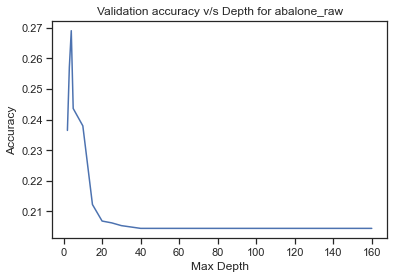

*** For abalone_lda dataset ***


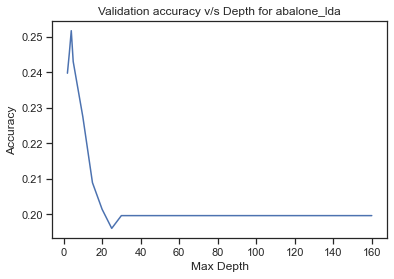

In [81]:
print("*** For abalone_raw dataset ***")
plot_tree_accuracy_plot(abalone_raw_results_dt,depths,"abalone_raw")

print("*** For abalone_lda dataset ***")
plot_tree_accuracy_plot(abalone_lda_results_dt,depths,"abalone_lda")

*** Confusion matrix for abalone_raw ***


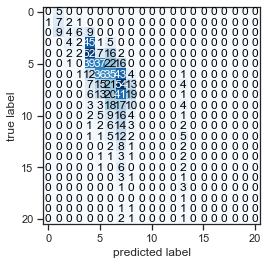

The accuracy with best tuned parameters: 25.358851674641148 % 


*** Confusion matrix for abalone_lda ***


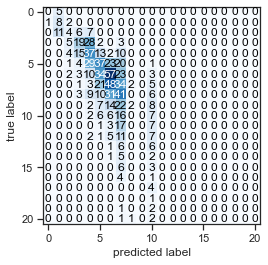

The accuracy with best tuned parameters: 24.2822966507177 % 




In [82]:
y_test, y_pred, abalone_raw_classifier = run_decision_tree_classifier(abalone_raw, abalone_target, abalone_raw_best_depth_dt)
cm = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cm,"abalone_raw")

y_test, y_pred, abalone_lda_classifier = run_decision_tree_classifier(abalone_lda, abalone_target, abalone_lda_best_depth_dt)
cm = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cm,"abalone_lda")

### 3.2.2. Wine

*** For wine_raw dataset ***


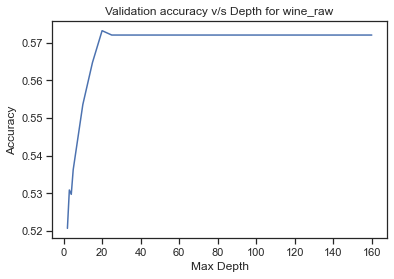

*** For wine_pca dataset ***


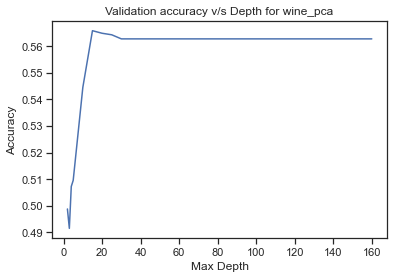

In [83]:
print("*** For wine_raw dataset ***")
plot_tree_accuracy_plot(wine_raw_results_dt,depths,"wine_raw")

print("*** For wine_pca dataset ***")
plot_tree_accuracy_plot(wine_pca_results_dt,depths,"wine_pca")

*** Confusion matrix for wine_raw ***


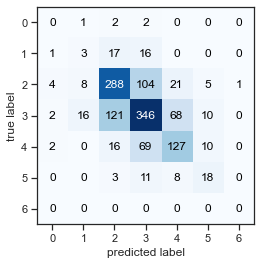

The accuracy with best tuned parameters: 60.15384615384616 % 


*** Confusion matrix for wine_pca ***


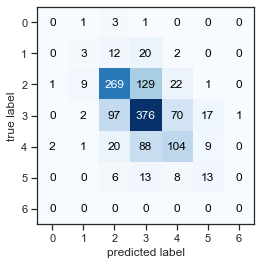

The accuracy with best tuned parameters: 58.84615384615385 % 




In [84]:
y_test, y_pred, wine_raw_classifier = run_decision_tree_classifier(wine_raw, wine_target, wine_raw_best_depth_dt)
cm = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cm,"wine_raw")

y_test, y_pred, wine_pca_classifier = run_decision_tree_classifier(wine_pca, wine_target, wine_pca_best_depth_dt)
cm = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cm,"wine_pca")

## 3.3. Interpretability

### 3.3.1. Abalone

In [85]:
plt.figure(figsize=(200,200))
tree.plot_tree(abalone_raw_classifier, feature_names = list(abalone_raw.columns))
plt.show()

Interpretation:<br>
1. We observe that first split happens using 'shell weight'. There is an interesting pattern that not all features are used for the split.<br>
2. We can support this observation by concluding that not all features are important as there was a reduction in dimentsionality when PCA/LDA was performed.

### 3.3.2. Wine

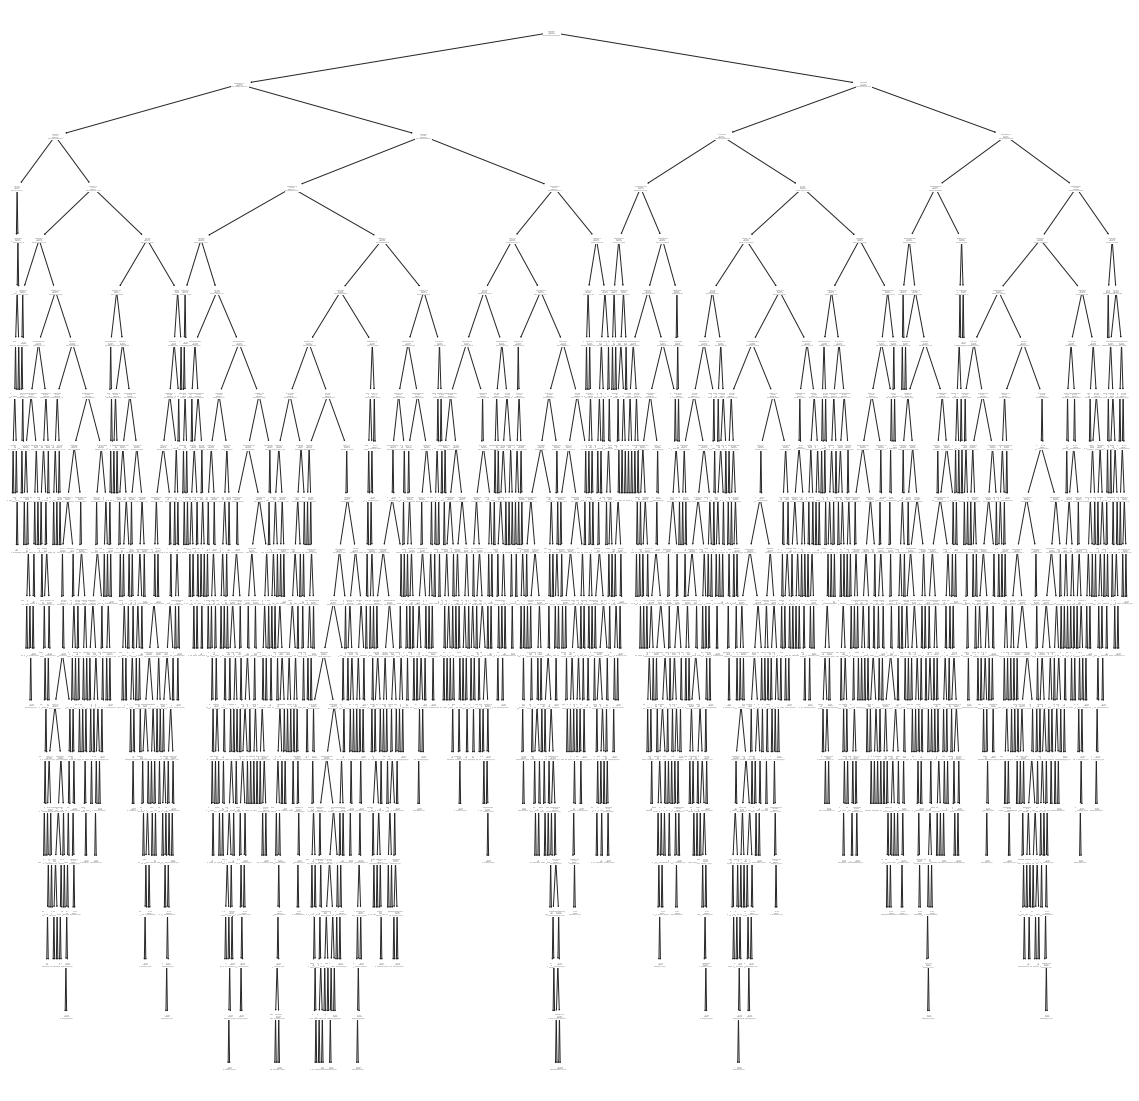

In [86]:
plt.figure(figsize=(20,20))
tree.plot_tree(wine_raw_classifier, feature_names = list(wine_raw.columns))
plt.show()

Interpretation:<br>
1. We observe that decision tree for wine dataset goes too deep for prediction. The max depth is 13 in this case and it can even go further
2. It can therefore result in overfitting of the data.
3. The result can be improved more if we using pruning here.

# 4. Random Forest Classifier

## 4.1 Cross validation with Random Forest 

What : Random forests is an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time.

Why :  For classification tasks, the output of the random forest is the class selected by most trees(majority vote). We use random forests for the same here on Abalone (Raw and LDA) datasets and Wine (Raw and PCA) datasets.

How : We have created a function by using the GridSearchCV and the RandomForestClassifier. using it's output, we have stored values of best parameters and calculated the accuracies accordingly for both Abalone (Raw and LDA) datasets and Wine (Raw and PCA) datasets.

### 4.1.0 Functions

In [87]:
# Defining range of depths
depths = [2,3,4,5,10,15,30,40,50,60,80,100,120,140,160]

# Defining range for no. of trees
trees = [2,3,4,5,6,7,8,9,10,20,30,40,60,80,100]

def run_random_forest_with_kfold(df,target):
    X_train, X_test, y_train, y_test = generate_train_test_splits(df,target)
    rfc=RandomForestClassifier(random_state=0)
    #rfc.fit(X_train, y_train)

    cv = KFold(n_splits=5, random_state=0, shuffle=True)
    parameters = [{'max_depth': depths,'n_estimators' : trees}]
    grid_search = GridSearchCV(estimator = rfc, param_grid = parameters, scoring = 'accuracy', cv = cv)
    grid_search.fit(X_train, y_train)
    best_accuracy = grid_search.best_score_
    best_parameters = grid_search.best_params_
    results = grid_search.cv_results_
    y_predict = grid_search.predict(X_test)
    return best_accuracy, best_parameters, results
    
def plot_accuracy_heatmap(results,trees,depths,type):
    mean_accuracies = results['mean_test_score'].tolist()
    df=pd.DataFrame(columns=['max_depth','n_estimators','list_of_acc_scores'])
    count=0
    for dep in depths:
        for tree in trees:
            append_list = [dep,tree,mean_accuracies[count]]
            df_len=len(df)
            df.loc[df_len] = append_list
            count = count+1
    piv_df = df.pivot("max_depth","n_estimators","list_of_acc_scores")
    plt.figure(figsize = (22,22))
    plt.title("Heatmap for accuracies of {}".format(type))
    sns.heatmap(piv_df,annot = True, fmt = '0.3f')
    plt.show()

### 4.1.1 Abalone

In [88]:
print("*** For Abalone Raw ***")
#applying random forest on Raw abalone and calculating best param and accuracy
abalone_raw_max_accuracy_rf , abalone_raw_best_params_rf, abalone_raw_results_rf = run_random_forest_with_kfold(abalone_raw, abalone_target)
abalone_raw_best_depth_rf = abalone_raw_best_params_rf['max_depth']
abalone_raw_best_tree_rf = abalone_raw_best_params_rf['n_estimators']
print("*** [Abalone-raw] [Random Forest] Best Accuracy: {} ".format(abalone_raw_max_accuracy_rf*100))
print("*** [Abalone-raw] [Random Forest] Best Depth:", abalone_raw_best_depth_rf)
print("*** [Abalone-raw] [Random Forest] Best Number of trees:", abalone_raw_best_tree_rf)
print("\n")

print("*** For Abalone LDA ***")
#applying random forest on LDA abalone and calculating best param and accuracy
abalone_lda_max_accuracy_rf , abalone_lda_best_params_rf, abalone_lda_results_rf = run_random_forest_with_kfold(abalone_lda, abalone_target)
abalone_lda_best_depth_rf = abalone_lda_best_params_rf['max_depth']
abalone_lda_best_tree_rf = abalone_lda_best_params_rf['n_estimators']
print("*** [Abalone-lda] [Random Forest] Best Accuracy: {} ".format(abalone_lda_max_accuracy_rf*100))
print("*** [Abalone-lda] [Random Forest] Best Depth:", abalone_lda_best_depth_rf)
print("*** [Abalone-lda] [Random Forest] Best Number of trees:", abalone_lda_best_tree_rf)


*** For Abalone Raw ***
*** [Abalone-raw] [Random Forest] Best Accuracy: 26.429383385694976 
*** [Abalone-raw] [Random Forest] Best Depth: 4
*** [Abalone-raw] [Random Forest] Best Number of trees: 10


*** For Abalone LDA ***
*** [Abalone-lda] [Random Forest] Best Accuracy: 26.399711787187957 
*** [Abalone-lda] [Random Forest] Best Depth: 5
*** [Abalone-lda] [Random Forest] Best Number of trees: 9


### 4.1.2 Wine

In [89]:
# For wine_raw
#applying random forest on Raw Wine and calculating best param and accuracy
print("*** For Wine raw ***")
wine_raw_max_accuracy_rf , wine_raw_best_params_rf, wine_raw_results_rf = run_random_forest_with_kfold(wine_raw, wine_target)
wine_raw_best_depth_rf = wine_raw_best_params_rf['max_depth']
wine_raw_best_tree_rf = wine_raw_best_params_rf['n_estimators']

print("*** [wine-raw] [Random Forest] Best Accuracy: {} ".format(wine_raw_max_accuracy_rf*100))
print("*** [wine-raw] [Random Forest] Best Depth:", wine_raw_best_depth_rf)
print("*** [wine-raw] [Random Forest] Best Number of Trees:", wine_raw_best_tree_rf)
print("\n")

#applying random forest on PCA Wine and calculating best param and accuracy
print("*** For Wine PCA ***")
wine_pca_max_accuracy_rf , wine_pca_best_params_rf, wine_pca_results_rf = run_random_forest_with_kfold(wine_pca, wine_target)
wine_pca_best_depth_rf = wine_pca_best_params_rf['max_depth']
wine_pca_best_tree_rf = wine_pca_best_params_rf['n_estimators']
print("*** [wine-pca] [Random Forests] Best Accuracy: {} ".format(wine_pca_max_accuracy_rf*100))
print("*** [wine-pca] [Random Forests] Best Depth:", wine_pca_best_depth_rf)
print("*** [wine-pca] [Random Forests] Best Number of Trees:", wine_pca_best_depth_rf)

*** For Wine raw ***
*** [wine-raw] [Random Forest] Best Accuracy: 66.26863848374917 
*** [wine-raw] [Random Forest] Best Depth: 30
*** [wine-raw] [Random Forest] Best Number of Trees: 100


*** For Wine PCA ***
*** [wine-pca] [Random Forests] Best Accuracy: 65.86481083882431 
*** [wine-pca] [Random Forests] Best Depth: 30
*** [wine-pca] [Random Forests] Best Number of Trees: 30


## 4.2 Heat Map for both parameters 

Here, we plot the heatmaps as is asked in the question to compare the two parameters with mean accuracies for each of them.

### 4.2.1 Accuracy plots vs Mean test scores for Abalone

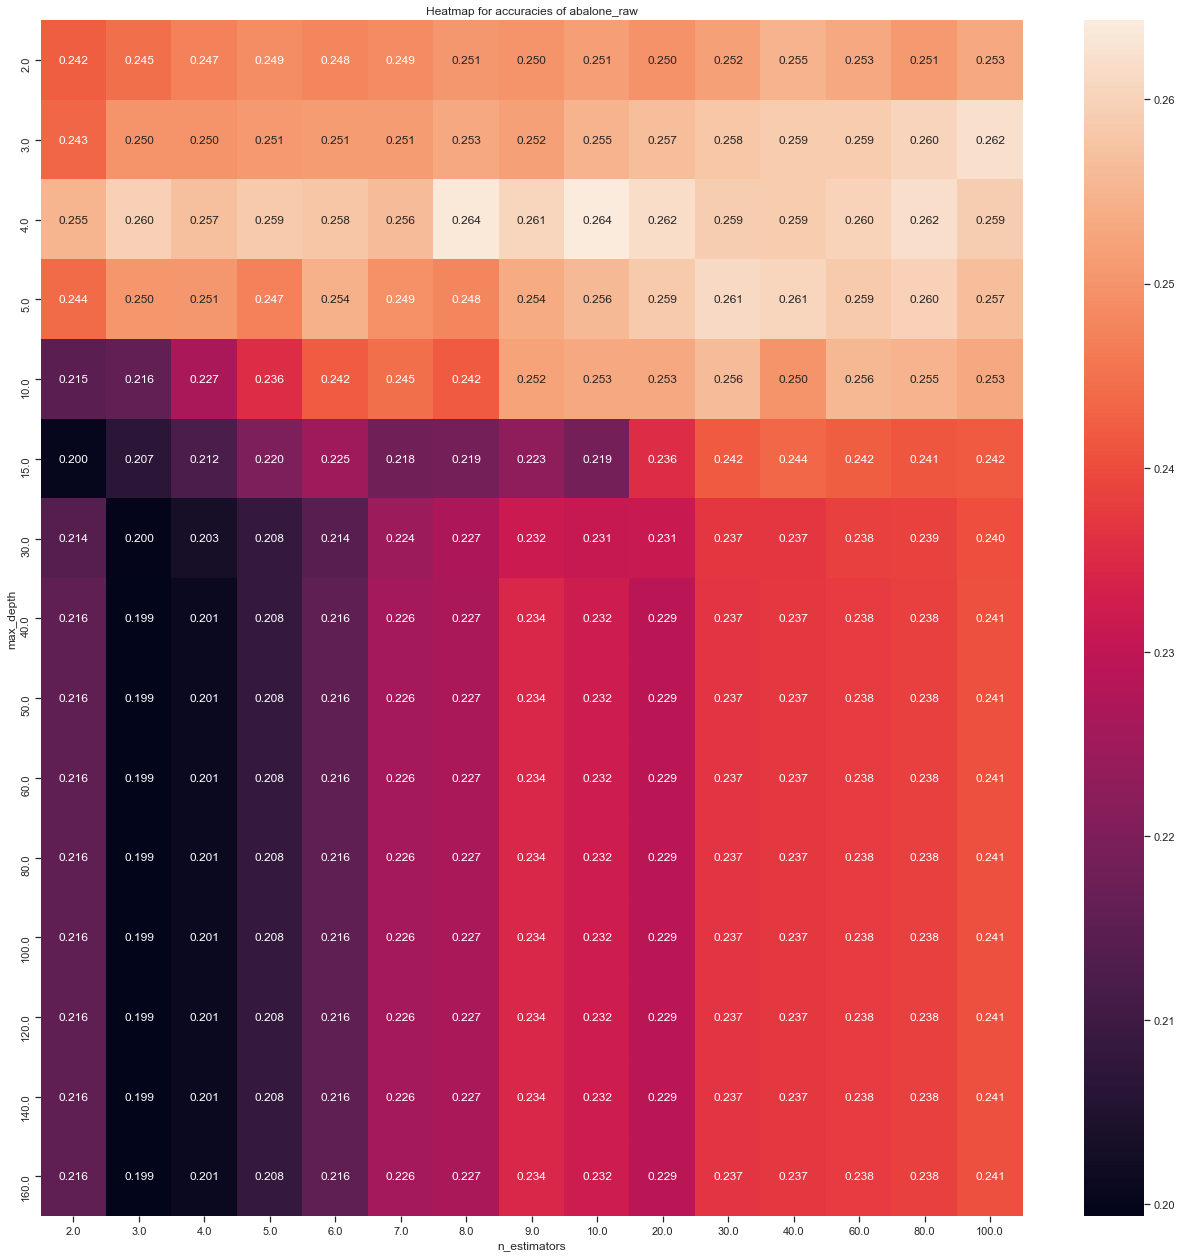

In [90]:
#Abalone Raw
plot_accuracy_heatmap(abalone_raw_results_rf,trees, depths,"abalone_raw")

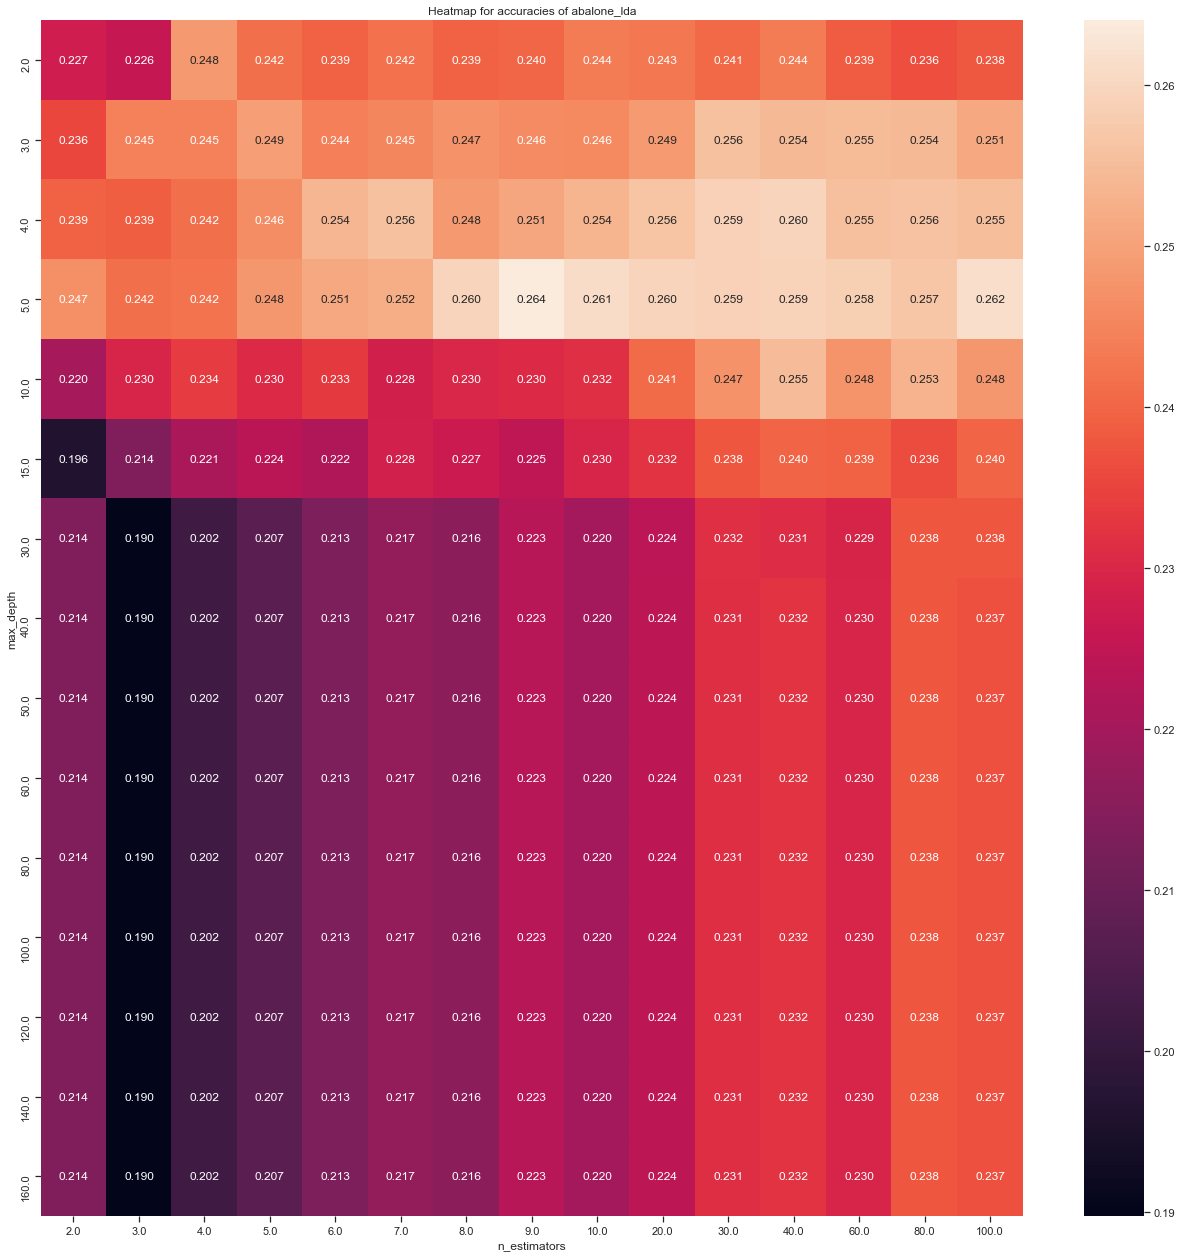

In [91]:
#Abalone LDA
plot_accuracy_heatmap(abalone_lda_results_rf,trees, depths,"abalone_lda")

### 4.2.2 Accuracy plots vs Mean test scores for Wine

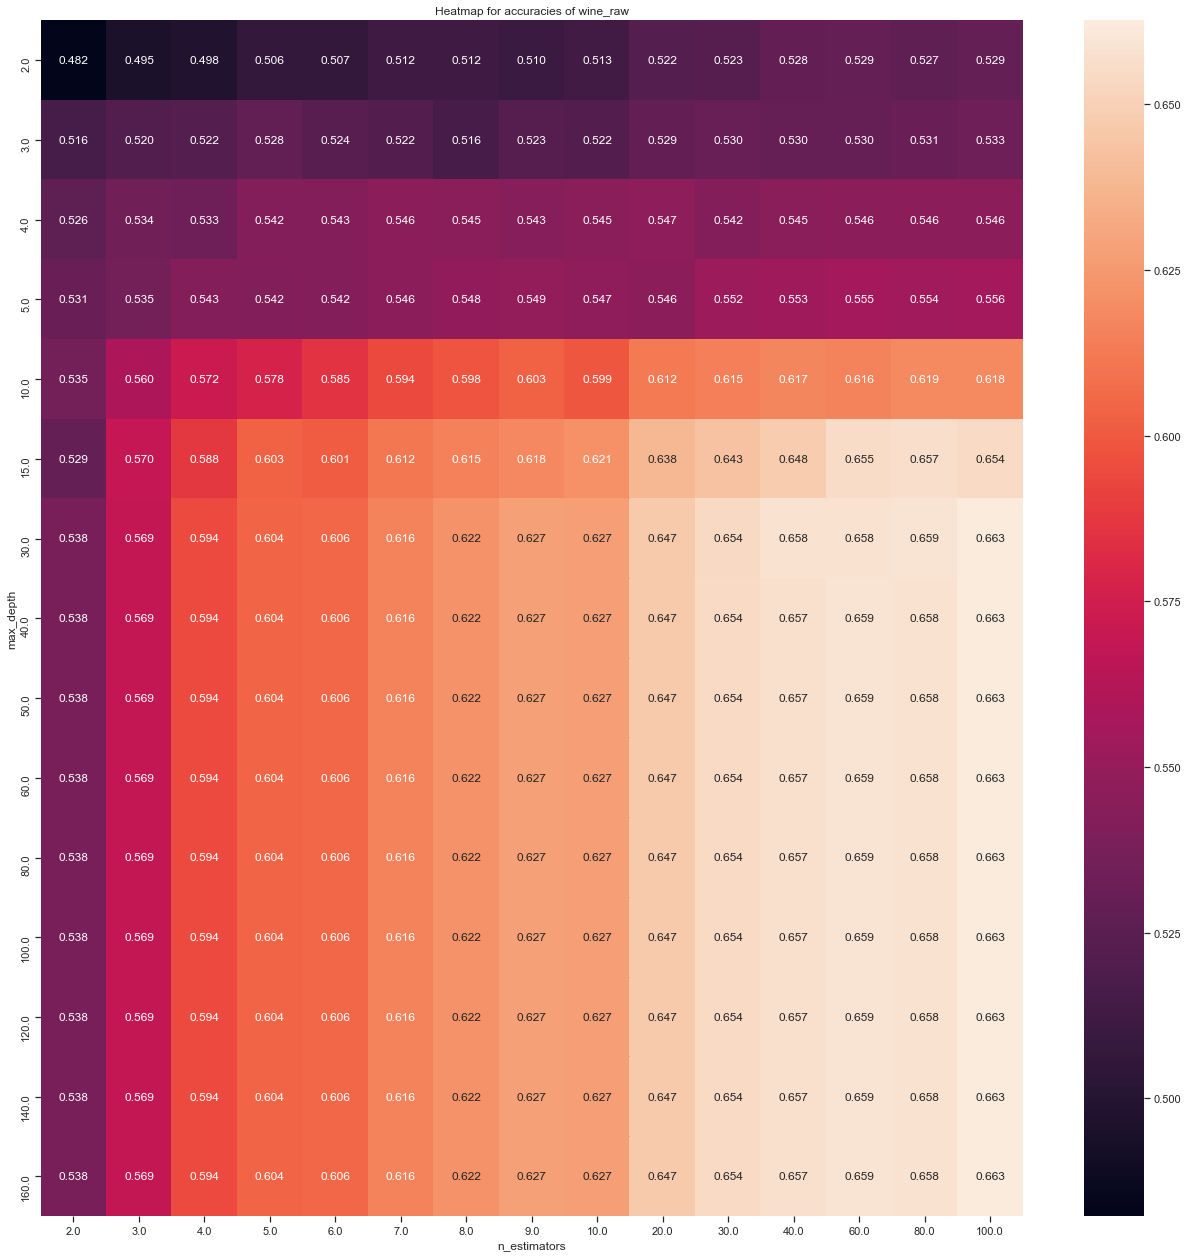

In [92]:
#Wine Raw
plot_accuracy_heatmap(wine_raw_results_rf,trees, depths,"wine_raw")

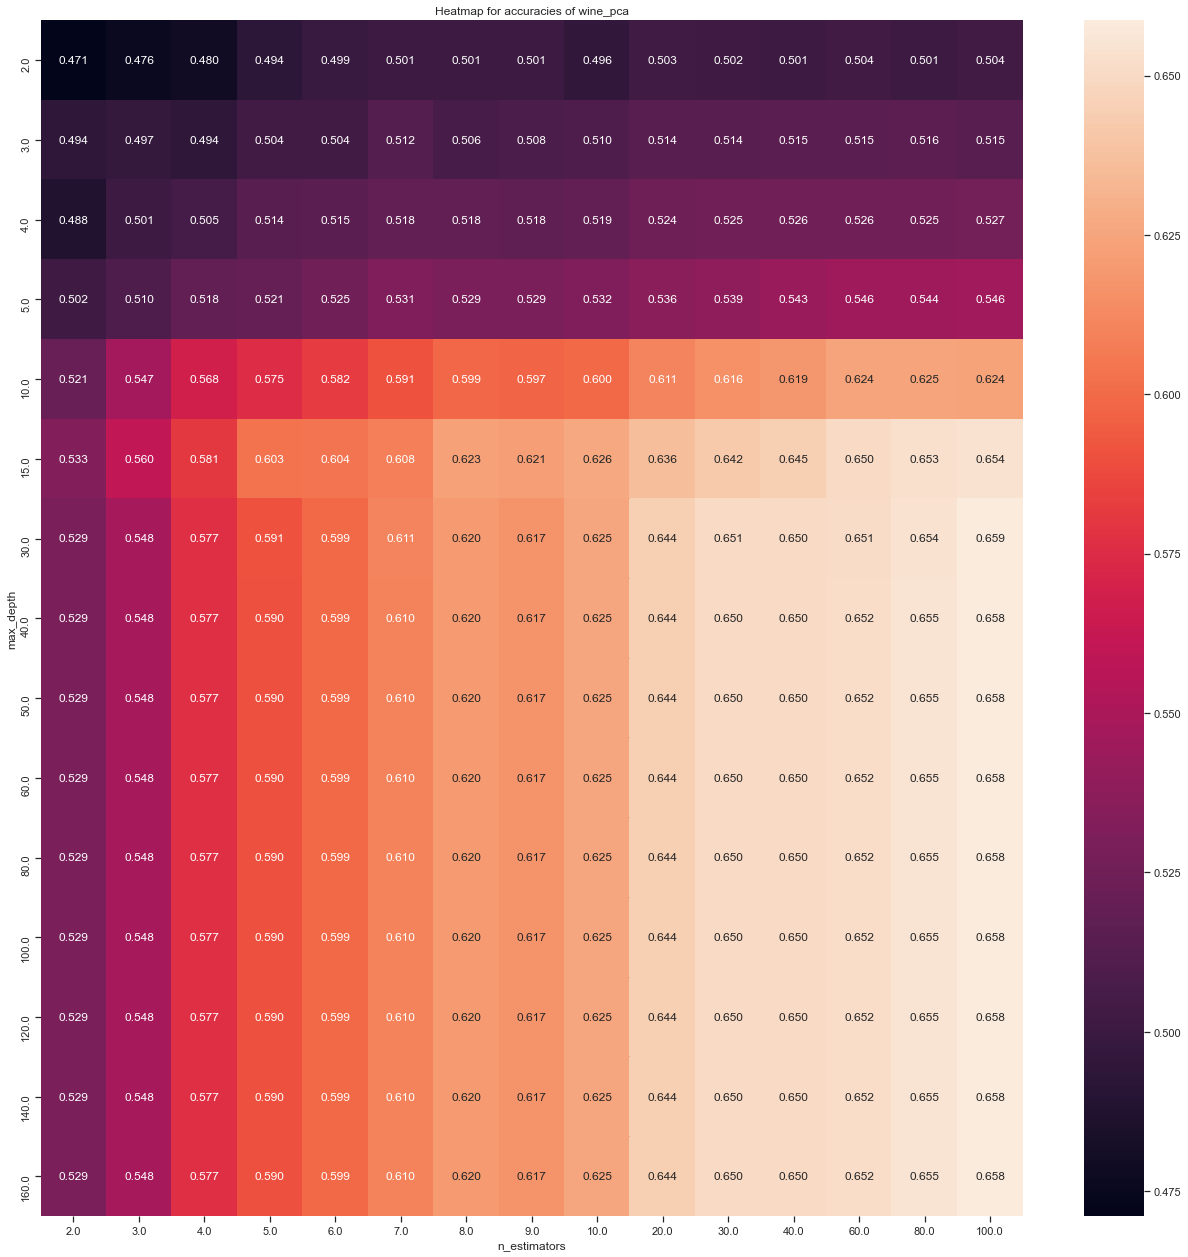

In [93]:
#Wine PCA
plot_accuracy_heatmap(wine_pca_results_rf,trees, depths,"wine_pca")

Analysis:
1. Abalone(Raw and LDA)

After applying the Random Forest Classifier on Abalone (raw and LDA) datasets, we find that the accuracies have increased dramatically as compared to the last classifier of Decision Trees. The best parameter for best accuracy is as follows:


Abalone Raw --> Best depth: 7   Best Trees: 100   Max Accuracy: 26.937694118489482


Abalone LDA --> Best depth: 7   Best Trees: 20    Max Accuracy: 26.728874090384252

2. Wine(Raw and PCA)

After applying the Random Forest Classifier on Winr (raw and PCA) datasets, we find that the accuracies have increased dramatically as compared to the last classifier of Decision Trees. The best parameter for best accuracy is as follows:

Wine Raw --> Best depth: 13   Best Trees: 100   Max Accuracy: 65.67205893240542

Wine PCA --> Best depth: 13   Best Trees: 100   Max Accuracy: 65.42205893240542

# 5. Gradient boosting Classifier

What : Gradient boosting is a machine learning technique used in regression and classification tasks, among others. It gives a prediction model in the form of an ensemble of weak prediction models, which are typically decision trees.

Why : The objective of Gradient Boosting classifiers is to minimize the loss, or the difference between the actual class value of the training example and the predicted class value.

How : We have created functions using GridSearchCV and GradientBoostingClassifier. using it's output, we have stored values of best parameters and calculated the accuracies accordingly for both Abalone (Raw and LDA) datasets and Wine (Raw and PCA) datasets. 

## 5.1 Cross Validation with gradient boosting

### 5.1.0 Functions

In [94]:
# Defining range for no. of estimators
n_estimators = [10,20,30,40,50,60,70,80,90]

def run_gradient_boosting_with_kfold(df,target):
    X_train, X_test, y_train, y_test = generate_train_test_splits(df,target)
    gbclassifier = GradientBoostingClassifier(random_state = 0)
    #gbclassifier.fit(X_train, y_train)

    cv = KFold(n_splits=5, random_state=0, shuffle=True)
    parameters = [{'n_estimators': n_estimators}]
    grid_search = GridSearchCV(estimator = gbclassifier, param_grid = parameters, scoring = 'accuracy', cv = cv)
    grid_search.fit(X_train, y_train)
    best_accuracy = grid_search.best_score_
    best_parameters = grid_search.best_params_
    results = grid_search.cv_results_
    y_predict = grid_search.predict(X_test) 
    return best_accuracy, best_parameters, results
    
def plot_gb_accuracy_plot(results,n_estimators,type):
    mean_accuracies = results['mean_test_score']

    plt.figure()
    sns.lineplot(n_estimators, mean_accuracies)
    plt.xlabel("n_estimators")
    plt.ylabel("Accuracy")
    plt.title("Validation accuracy v/s Depth for {}".format(type))
    plt.show()

### 5.1.1 Abalone 

In [95]:
print("*** For Abalone Raw ***")
#applying gradient boosting on Raw abalone
abalone_raw_max_accuracy_gb , abalone_raw_best_params_gb, abalone_raw_results_gb = run_gradient_boosting_with_kfold(abalone_raw, abalone_target)
abalone_raw_best_tree_gb = abalone_raw_best_params_gb['n_estimators']
print("*** [Abalone-raw] [Gradient boosting] Best Accuracy: {} ".format(abalone_raw_max_accuracy_gb*100))
print("*** [Abalone-raw] [Gradient boosting] Best n_estimators:", abalone_raw_best_tree_gb)
print("\n")

print("*** For Abalone LDA ***")
#applying random forest on LDA abalone
abalone_lda_max_accuracy_gb , abalone_lda_best_params_gb, abalone_lda_results_gb = run_gradient_boosting_with_kfold(abalone_lda, abalone_target)
abalone_lda_best_tree_gb = abalone_lda_best_params_gb['n_estimators']
print("*** [Abalone-lda] [Gradient boosting] Best Accuracy: {} ".format(abalone_lda_max_accuracy_gb*100))
print("*** [Abalone-lda] [Gradient boosting] Best n_estimators:", abalone_lda_best_tree_gb)


*** For Abalone Raw ***
*** [Abalone-raw] [Gradient boosting] Best Accuracy: 25.351539074317735 
*** [Abalone-raw] [Gradient boosting] Best n_estimators: 70


*** For Abalone LDA ***
*** [Abalone-lda] [Gradient boosting] Best Accuracy: 24.36364938284865 
*** [Abalone-lda] [Gradient boosting] Best n_estimators: 20


### 5.1.2 Wine

In [96]:
# For wine_raw
#applying gradient boosting on Raw Wine
print("*** For Wine raw ***")
wine_raw_max_accuracy_gb , wine_raw_best_params_gb, wine_raw_results_gb = run_gradient_boosting_with_kfold(wine_raw, wine_target)
wine_raw_best_tree_gb = wine_raw_best_params_gb['n_estimators']

print("*** [wine-raw] [Gradient boosting] Best Accuracy: {} ".format(wine_raw_max_accuracy_gb*100))
print("*** [wine-raw] [Gradient boosting] Best n_estimators:", wine_raw_best_tree_gb)
print("\n")

#applying random forest on PCA Wine
print("*** For Wine PCA ***")
wine_pca_max_accuracy_gb , wine_pca_best_params_gb, wine_pca_results_gb = run_gradient_boosting_with_kfold(wine_pca, wine_target)
wine_pca_best_tree_gb = wine_pca_best_params_gb['n_estimators']
print("*** [wine-pca] [Gradient boosting] Best Accuracy: {} ".format(wine_pca_max_accuracy_gb*100))
print("*** [wine-pca] [Gradient boosting] Best Number of Trees:", wine_raw_best_tree_gb)

*** For Wine raw ***
*** [wine-raw] [Gradient boosting] Best Accuracy: 58.322240319834165 
*** [wine-raw] [Gradient boosting] Best n_estimators: 90


*** For Wine PCA ***
*** [wine-pca] [Gradient boosting] Best Accuracy: 58.47632708965722 
*** [wine-pca] [Gradient boosting] Best Number of Trees: 90


## 5.2 Plot for accuracy measurement

Here, we plot the lineplots as is asked in the question to compare the n_estimators parameters with mean accuracies for each of the datasets Abalone(Raw and LDA) and Wine(Raw and PCA).

### 5.2.1 Abalone

*** For abalone_raw dataset ***


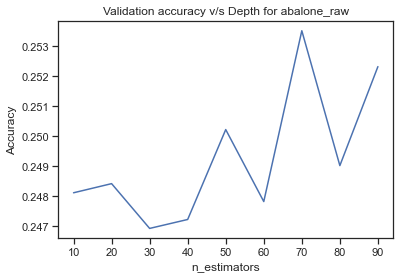

*** For abalone_lda dataset ***


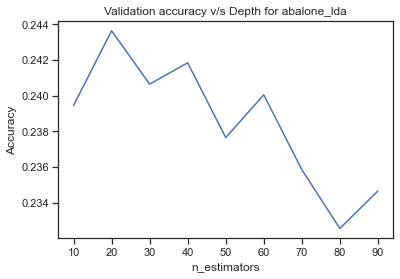

In [97]:
#For Abalone raw
print("*** For abalone_raw dataset ***")
plot_gb_accuracy_plot(abalone_raw_results_gb,n_estimators,"abalone_raw")


#For abalone LDA
print("*** For abalone_lda dataset ***")
plot_gb_accuracy_plot(abalone_lda_results_gb,n_estimators,"abalone_lda")

### 5.2.2 Wine

*** For Wine_raw dataset ***


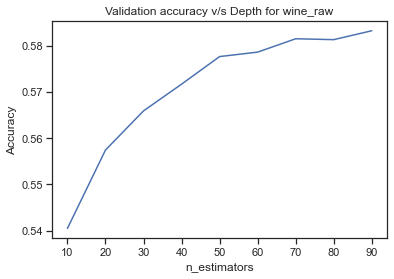

*** For wine_pca dataset ***


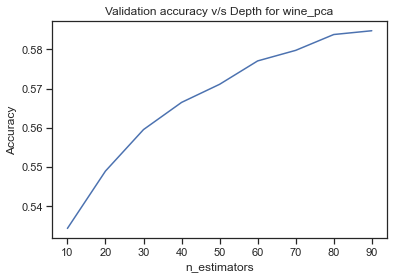

In [98]:
#For Wine raw
print("*** For Wine_raw dataset ***")
plot_gb_accuracy_plot(wine_raw_results_gb,n_estimators,"wine_raw")


#For wine PCA
print("*** For wine_pca dataset ***")
plot_gb_accuracy_plot(wine_pca_results_gb,n_estimators,"wine_pca")

Analysis:
1. Abalone(Raw and LDA)

After applying Gradient Boosting, we find that the Abalone dataset for both gives a better accuracy than the decision trees classifier but is still less accurate than the Random Forest classifier.

Abalone Raw --> Best n_estimators: 70  Max accuracy: 25.351539074317735


Abalone LDA --> Best n_estimators: 20  Max accuracy: 24.36364938284865 

2. Wine(Raw and PCA)

After applying Gradient Boosting, we find that the Wine dataset for both gives a better accuracy than the decision trees classifier but is still less accurate than the Random Forest classifier.

Wine Raw --> Best n_estimators: 90  Max accuracy: 58.76382616421115

Wine PCA --> Best n_estimators: 90  Max accuracy: 57.53307544236323 

# 6. Final Results

## 6.1 Accuracy Table 

### 6.1.1 Abalone

Below is the code to make the table for plotting accuracies 

In [99]:
comparison_abalone = pd.DataFrame({" ": [], \
                           "setting": [], \
                           "abalone_raw": [], \
                           "abalone_lda": []})
comparison_abalone.loc[len(comparison_abalone.index)] = ["kNN", zscore_best_k, zscore_max_accuracy, abalone_lda_max_accuracy*100]
comparison_abalone.loc[len(comparison_abalone.index)] = ["Naive Bayes", "Complement and " + str(abalone_raw_best_params_nbc), abalone_raw_max_accuracy_nbc*100 , abalone_lda_max_accuracy_nbc*100]
comparison_abalone.loc[len(comparison_abalone.index)] = ["Naive Bayes", "Multinomial and " + str(abalone_raw_best_params_nbm), abalone_raw_max_accuracy_nbm*100, abalone_lda_max_accuracy_nbc*100]
comparison_abalone.loc[len(comparison_abalone.index)] = ["Decision Tree", abalone_raw_best_depth_dt, abalone_raw_max_accuracy_dt*100, ""]
comparison_abalone.loc[len(comparison_abalone.index)] = ["Decision Tree", abalone_lda_best_depth_dt, "",abalone_lda_max_accuracy_dt*100]
comparison_abalone.loc[len(comparison_abalone.index)] = ["Random Forest", "Best Depth " + str(abalone_raw_best_depth_rf) +" Best n_estimators " + str(abalone_raw_best_tree_rf), abalone_raw_max_accuracy_rf*100, ""]
comparison_abalone.loc[len(comparison_abalone.index)] = ["Random Forest", "Best Depth " + str(abalone_lda_best_depth_rf)+ " Best n_estimators " + str(abalone_lda_best_tree_rf), "", abalone_lda_max_accuracy_rf*100]
comparison_abalone.loc[len(comparison_abalone.index)] = ["Gradient Boosting", abalone_raw_best_tree_gb, abalone_raw_max_accuracy_gb*100,""]
comparison_abalone.loc[len(comparison_abalone.index)] = ["Gradient Boosting", abalone_lda_best_tree_gb,"", abalone_lda_max_accuracy_gb*100]

comparison_abalone

setting abalone_raw  \
0                kNN                               49.0   27.751196   
1        Naive Bayes     Complement and {'alpha': 10.0}   17.299974   
2        Naive Bayes     Multinomial and {'alpha': 1.0}   21.101519   
3      Decision Tree                                  4   26.907217   
4      Decision Tree                                  4               
5      Random Forest  Best Depth 4 Best n_estimators 10   26.429383   
6      Random Forest   Best Depth 5 Best n_estimators 9               
7  Gradient Boosting                                 70   25.351539   
8  Gradient Boosting                                 20               

  abalone_lda  
0   29.545455  
1   23.705414  
2   23.705414  
3              
4   25.173465  
5              
6   26.399712  
7              
8   24.363649

### 6.1.2 Wine

In [100]:
comparison_wine = pd.DataFrame({" ": [], \
                           "setting": [], \
                           "wine_raw": [], \
                           "wine_pca": []})
comparison_wine.loc[len(comparison_wine.index)] = ["kNN", quality_zscore_best_k, quality_zscore_max_accuracy, wine_pca_max_accuracy*100]
comparison_wine.loc[len(comparison_wine.index)] = ["Naive Bayes", "Complement and " + str(wine_raw_best_params_nbc), wine_raw_max_accuracy_nbc*100 , wine_pca_max_accuracy_nbc*100]
comparison_wine.loc[len(comparison_wine.index)] = ["Naive Bayes", "Multinomial and " + str(wine_raw_best_params_nbm), wine_raw_max_accuracy_nbm*100, wine_pca_max_accuracy_nbc*100]
comparison_wine.loc[len(comparison_wine.index)] = ["Decision Tree", wine_raw_best_depth_dt, wine_raw_max_accuracy_dt*100, ""]
comparison_wine.loc[len(comparison_wine.index)] = ["Decision Tree", wine_pca_best_depth_dt, "",wine_pca_max_accuracy_dt*100]
comparison_wine.loc[len(comparison_wine.index)] = ["Random Forest", "Best Depth " + str(wine_raw_best_depth_rf)+ " Best n_estimators " + str(wine_raw_best_tree_rf), wine_raw_max_accuracy_rf*100, ""]
comparison_wine.loc[len(comparison_wine.index)] = ["Random Forest", "Best Depth " + str(wine_pca_best_depth_rf) +" Best n_estimators " + str(wine_pca_best_tree_rf), "", wine_pca_max_accuracy_rf*100]
comparison_wine.loc[len(comparison_wine.index)] = ["Gradient Boosting", wine_raw_best_tree_gb, wine_raw_max_accuracy_gb*100,""]
comparison_wine.loc[len(comparison_wine.index)] = ["Gradient Boosting", wine_pca_best_tree_gb,"", wine_pca_max_accuracy_gb*100]

comparison_wine

setting   wine_raw  \
0                kNN                                 35.0  56.769231   
1        Naive Bayes        Complement and {'alpha': 1.0}  43.043718   
2        Naive Bayes      Multinomial and {'alpha': 0.01}   47.85415   
3      Decision Tree                                   20  57.321148   
4      Decision Tree                                   15              
5      Random Forest  Best Depth 30 Best n_estimators 100  66.268638   
6      Random Forest  Best Depth 30 Best n_estimators 100              
7  Gradient Boosting                                   90   58.32224   
8  Gradient Boosting                                   90              

    wine_pca  
0  67.461538  
1  43.255849  
2  43.255849  
3             
4  56.590027  
5             
6  65.864811  
7             
8  58.476327

## 6.2 Comment on classification accuracy along with use of dimensionality reduction

Best pipeline for abalone-raw: knn (default parameters) <br>
Best pipeline for  abalone-lda: weighted KNN <br>
Best pipeline for wine-raw: weighted KNN <br>
Best pipeline for wine-pca: Random Forest classifier <br>

### 6.2.1 Abalone

For Abalone, the accuracies for Random Forest Classifier is the highest as compared to Naive Bayes, Decision Trees classifier and Gradient boosting. The accuracies are in the following ascending order Naive Bayes, Decision Trees Classifier, Gradient Boosting classifier and Random Forest Classifier.

The exact accuracies can be seen in the above dataframe in the heading 6.1.1.

#### KNN

KNN classifier shows best accuracy for all the datasets whether it is LDA or raw. This is the most apt classifier as we have discussed below why others were not suitable to give max accuracy.

#### Naive Bayes

For Complement Naive Bayes, we have the minimum accuracy for abalone raw dataset and it is significantly increased in abalone lda dataset. The best alpha for both is alpha = 10. For multinomial, it is the same case but it's accuracy is slightly better than that of complement Naive Bayes classifer. This is so because Naive Bayes assumes independence of the dimensions but the abalone dataset is a highly correlated dataset and hence predicts the least accuracy. 


The reduced dimensionality does help significantly for the Naive Bayes classifier as it reduces the correlated dimensions and hence is able to perform better with reduced dimensions.

#### Decision Tree Classifier

For Decision Tree classifier, we find that it actually performs better than Naive Bayes but is still the second-last best accuracy in the dataframe above. For abalone raw, we find max_depth is less and gives a better accuracy than on abalone lda which even has increased max_depth. This is so because it is overfitting the model and hence the accuracy is decreasing.

As explained above, we see abalone raw dataset shows a better accuracy score than abalone lda dataset. Hence, we find that reduced dimensionality here did not add to it but rather deteriorated the model.

#### Random Forest Classifier

For Random Forest classifier, we compute that it performs the best with the best accuracy and similar settings for both abalone raw and abalone lda. It performs the best because the abalone dataset is a highly correlated dataset and random forest workd best for a correlated dataset as it works on the the principal of majority votes. Random forests perform well for multi-class object detection, which has a lot of statistical noise.

The dimensionality reduction rather reduces the accuracy but very minutely because it has less dimensions. So, here also LDA didn't actually make anything better.

#### Gradient Boosting Classifier

For Gradient Boosting classifier, we see that it performs the second best in terms of accuracy after Random Forest classifier. This is so because it is not a very unbalanced dataset. It is unbalanced but not too much and hence performs lesser than the random forest classifier.

The reduced dimensionality rather reduces the accuracy for Gradient Boosting classifier. Hence, LDA doesn't help overall very much.

#### Additional observations

We find that only Naive Bayes is helped by the dimensionality reduction for predicting better accuracy and no other classifier actually gets better by using LDA although overall LDA gives better accuracy for Abalone than PCA.

### 6.2.2 Wine

For Abalone, the accuracies for Random Forest Classifier is the highest as compared to Naive Bayes, Decision Trees classifier and Gradient boosting. The accuracies are in the following ascending order Naive Bayes, Decision Trees Classifier, Gradient Boosting classifier and Random Forest Classifier.

The exact accuracies can be seen in the above dataframe in the heading 6.1.2.

#### KNN

KNN classifier shows best accuracy for all the datasets whether it is PCA or raw. This is the most apt classifier as we have discussed below why others were not suitable to give max accuracy.

#### Naive Bayes

For Complement Naive Bayes, we have the minimum accuracy for wine raw dataset and it is marginally decreases in wine pca dataset. The best alpha for both is alpha = 0.5. For multinomial, the accuracy drops significantly for wine pca dataset. This is so because Naive Bayes assumes independence of the dimensions and wine dataset has a large number of dimensions which are a bit correlated so reducing the dimensions actually drops the accuracy significantly.


Reducing dimensions didn't actually work very well forMultinomial Naive Bayes Classifier in the Wine dataset

#### Random Forest Classifier

For Random Forest classifier, we compute that it performs the best with the best accuracy and similar settings for both wine raw and wine pca datasets. It performs the best because the wine dataset has a lot of statistical noise in the datset and random forest works best for multi-class object or continuous target by the law of majority votes. Random forests perform well for multi-class object detection, which has a lot of statistical noise.

The dimensionality reduction rather reduces the accuracy but very minutely(0.2%) because it has less dimensions. So, here PCA didn't really help with the accuracy.

#### Gradient Boosting Classifier

For Gradient Boosting classifier, we see that it performs the second best in terms of accuracy after Random Forest classifier. This is so because it is a very unbalanced dataset. It is unbalanced but not too much and hence performs lesser than the random forest classifier.

The reduced dimensionality rather reduces the accuracy for Gradient Boosting classifier. Hence, LDA doesn't help overall very much.

#### Additional Observations

For wine, dimensionality reduction doesn't really help any where in increasing the accuracy because the number of principal components involved are a lot and hence it's not actually aiding the reason why we use dimensionality reduction. Sure, in a few classifiers the values don't change much but it still is a bit less as compared to accuracy on raw dataset.

# List of References:

[1] https://towardsdatascience.com/predicting-wine-quality-with-several-classification-techniques-179038ea6434#30ac

[2] https://stackoverflow.com/questions/35265613/pandas-cross-join-no-columns-in-common

[3] https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

[4] https://towardsdatascience.com/decision-trees-the-maths-the-theory-the-benefits-6315abd2f10a

[5] https://origin.geeksforgeeks.org/complement-naive-bayes-cnb-algorithm/

[6] https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

[7] https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.DecisionTreeClassifier.html

[8] https://www.statology.org/z-score-normalization/#:~:text=Z%2Dscore%20normalization%20refers%20to,the%20standard%20deviation%20is%201

[9] https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm

[10] https://www.codecademy.com/article/normalization#:~:text=Min%2Dmax%20normalization%20is%20one,decimal%20between%200%20and%201.

[11] https://en.wikipedia.org/wiki/Naive_Bayes_classifier